Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**

# Import & Helpers

In [3]:
#! mlflow server --host 127.0.0.1 --port 8080

In [65]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import datetime as dt
import numpy as np
import re
import random

import sys
sys.path.insert(0, "C:/Users/czump/Documents/GitHub/iu_case_study_psp_selection/src")
from helpers import cyclical_encoding, track_model, train_model, hp_tune_model

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")
%matplotlib inline
# plot dimensions
plot_width = 12
plot_height = 8
palette_success ={0: color_pal[1], 1: color_pal[2]}

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score, recall_score, make_scorer, brier_score_loss, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

import mlflow
from mlflow.models import infer_signature

In [5]:
# parameter
rs = 23 # random state

# MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# date of today as string
dt_today = str(dt.date.today())

# Data preparation 2

In [6]:
# for TRAINING: load first attempt per customer transaction per PSP
df_trx = (pd.read_excel("../data/04_processed/df_trx_training.xlsx", sheet_name="df_trx")
          .drop(columns=["Unnamed: 0"])
          .rename(columns={"x_tmsp":"meta_tmsp"}))

In [7]:
# raw x- and y-variables
x_ = [x for x in list(df_trx.columns) if re.match("^x_", x)!=None]
y_ = [y for y in list(df_trx.columns) if re.match("^y_", y)!=None]
meta_ = [m for m in list(df_trx.columns) if m.find("meta_")!=-1]

In [8]:
df_trx[x_].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37782 entries, 0 to 37781
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   x_country                  37782 non-null  object 
 1   x_amount                   37782 non-null  int64  
 2   x_psp                      37782 non-null  object 
 3   x_3d_secured               37782 non-null  int64  
 4   x_card                     37782 non-null  object 
 5   x_tmsp_wd_str              37782 non-null  object 
 6   x_tmsp_h_sin               37782 non-null  float64
 7   x_tmsp_h_cos               37782 non-null  float64
 8   x_tmsp_wd_sin              37782 non-null  float64
 9   x_tmsp_wd_cos              37782 non-null  float64
 10  x_enc_country_Austria      37782 non-null  bool   
 11  x_enc_country_Germany      37782 non-null  bool   
 12  x_enc_country_Switzerland  37782 non-null  bool   
 13  x_enc_psp_Goldcard         37782 non-null  boo

In [9]:
df_trx[meta_].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37782 entries, 0 to 37781
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   meta_tmsp              37782 non-null  datetime64[ns]
 1   meta_customer_trx_id   37782 non-null  int64         
 2   meta_customer_atpt_no  37782 non-null  int64         
 3   meta_psp_trx_id        37782 non-null  int64         
 4   meta_psp_atpt_no       37782 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.4 MB


Je nach Modell gibt es 2 Features-Sets:<br>

Für Modelle, die numerische Features benötigen: 
- 16 Features
- davon 6 numerische Features, die skaliert werden müssen
- und 10 Features vom Typ Boolean, die aus dem One Hot Encoding entstanden sind und als Integer encoded werden<br>

Für Modelle, bei denen der Typ der Features egal ist:
- 7 Features
- davon 2 numerische Features vom Typ Integer
- und 5 categorial Features vom Typ Object

In [10]:
# categorize features
feat_object_native = list(df_trx[x_].select_dtypes(include="object").columns) # original features of type object
#feat_object_bool_enc = list(df_trx[x_].select_dtypes(include="bool").columns) # encoded object features as bool
feat_num = list(df_trx[x_].select_dtypes(include="int").columns) # numerical features for scaling

## Train-Test-Split
Indirekter Train-Test-Split auf Basis der Customer-Transaction-ID meta_customer_trx_id.<br>
Damit wird sichergestellt, dass alle Attempts zu einem Kundenvorgang entweder nur im Trainings- oder nur im Test-Datensatz sind. Damit stehen dann später Versuche mit mehreren PSPs für einen Kundenvorgang zur Evaluierung zur Verfügung.

In [11]:
# TRAIN-TEST-SPLIT: shuffle and split by customer_trx_id
trx_id_train, trx_id_test  = train_test_split(df_trx["meta_customer_trx_id"].unique(), test_size=0.2, random_state=rs, shuffle=True)

# create x- and y-sets
x_train = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_train)].loc[:, x_]
x_test = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_test)].loc[:, x_]
y_train = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_train)].loc[:, y_]
y_test = df_trx[df_trx["meta_customer_trx_id"].isin(trx_id_test)].loc[:, y_]
# to array/series
y_train= y_train.iloc[:, 0]
y_test= y_test.iloc[:, 0]

In [13]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
print(f"Trainings data set consists of {train_size} records, while the test data set consists of {test_size} records.")

Trainings data set consists of 30270 records, while the test data set consists of 7512 records.


## Feature Engineering Pipeline

In [14]:
# column transformer for models requiring numerical, scaled input features
coltransformer_4numerical = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include="number")), 
    (OrdinalEncoder(), make_column_selector(dtype_include="bool"))
)

## Features

In [15]:
# for model with numerical input
coltransformer_4numerical.fit(x_train)
x_train_numerical = coltransformer_4numerical.transform(x_train)
x_test_numerical = coltransformer_4numerical.transform(x_test)

In [16]:
# names of transformed features
transformed_features = coltransformer_4numerical.get_feature_names_out()

In [17]:
# for model with raw input
x_train_raw = x_train[feat_num + feat_object_native]
x_test_raw = x_test[feat_num + feat_object_native]

# Modeling no. 1 

## Test design
Ziele:
- erfolgreiche Transaktionen in Abhängigkeit vom PSP (und den anderen Umständen) erkennen
- positiv = success
- wir müssen dem Kunden einen PSP zuordnen und wollen daher den PSP wählen, der die höchste Erfolgswahrscheinlichkeit hat
- keine PSP zu wählen ist keine Option
  
Vergleich der Modelle:
- Wir sind nicht nur an der Klassifikation an sich interessiert, sondern v.a. auch an der Wahrscheinlichkeit für einen Erfolg abhängig von dem PSP. Der Predictor muss keine fixe Vorhersage über Erfolg/Misserfolg treffen, sondern in Abhängigkeit vom PSP die Erfolgswahrscheinlichkeit berechnen (es wird kein Threshold festgelegt).
- AUC ist eine Vergleichsmetrik, die unabhängig vom gewählten Threshold ist.

Weitere Metriken zur Bewertung der Performance, aber nicht entscheidend:
- Precision meiner Vorhersage: keine Falschpositiven, um mehrfache Transaktionsgebühren zu sparen
- Recall/TPR/Sensitivity: möglichst viele erfolgreiche Transaktionen vorhersagen, um eine Auswahl an PSPs zu haben, um die Kosten minimieren zu können
- F1-Score als harmonisches Mittel

## Baseline model
2 Strategien kommen in Frage:
- most_frequent: macht wenig Sinn, weil dann kein Erfolg vorhergesagt wird, so dass Precision nicht berechnet werden kann. Recall/Sensitity ist ebenfalls = 0
- stratified: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.

In [18]:
# Training and prediction
baseline_clf = DummyClassifier(strategy="stratified", random_state=rs)
baseline_clf.fit(x_train_raw, y_train)

y_pred_baseline = baseline_clf.predict(x_test_raw)
y_pred_baseline_prob = baseline_clf.predict_proba(x_test_raw)
auc = roc_auc_score(y_test, y_pred_baseline_prob[:, 1], average="macro")
prec = precision_score(y_test, y_pred_baseline, zero_division=np.nan)
recall = recall_score(y_test, y_pred_baseline, zero_division=np.nan)
f1 = f1_score(y_test, y_pred_baseline, zero_division=np.nan)

print(f"Baseline-model")
print(f"with AUC: {auc:.2f}")
print(f"with precision: {prec:.2f}")
print(f"with recall: {recall:.2f}")
print(f"and F1-score: {f1:.2f}")

Baseline-model
with AUC: 0.50
with precision: 0.21
with recall: 0.21
and F1-score: 0.21


## 1st training of models (w/ class_weights)
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression<br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC<br>
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis<br>
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn-ensemble-gradientboostingclassifier<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

In [19]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight

array([0.6292616, 2.4340624])

In [20]:
# collect all models
# names
first_step_clf_names = ["Baseline model stratified", 
                        "Logistic Regression", 
                        "Naive Bayes", 
                        "KNN", 
                        "Decision Tree", 
                        "Linear SVM",  
                        "LDA", 
                        "QDA",
                        "Random Forest", 
                        "Gradient Boosting", 
                        "Extra Trees"]

# configure random see
params_rs = {"random_state": rs}

# sklearn models
first_step_clf = [DummyClassifier(strategy="stratified", **params_rs), 
                  LogisticRegression(class_weight="balanced", penalty=None, **params_rs), 
                  CategoricalNB(), 
                  KNeighborsClassifier(), 
                  DecisionTreeClassifier(class_weight="balanced", **params_rs),
                  LinearSVC(class_weight="balanced", **params_rs),
                  LinearDiscriminantAnalysis(), 
                  QuadraticDiscriminantAnalysis(),
                  RandomForestClassifier(class_weight="balanced_subsample", **params_rs), 
                  GradientBoostingClassifier(**params_rs), 
                  ExtraTreesClassifier(class_weight="balanced_subsample", **params_rs)]

# feature mode for model
first_step_feat_mode = ["raw", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric"]

first_step_zip = zip(first_step_clf_names, first_step_clf, first_step_feat_mode)
print(f"length of clf_names {len(first_step_clf_names)} & clf {len(first_step_clf)} & feat_mode {len(first_step_feat_mode)}")

length of clf_names 11 & clf 11 & feat_mode 11


Training and logging of model Baseline model stratified as classifier DummyClassifier(random_state=23, strategy='stratified') with feature mode raw
Has NO feature importances
For Baseline model stratified: Run logged in MLflow with 6843f5404f1c434c86211d2da7569064.
---------------------- 

Training and logging of model Logistic Regression as classifier LogisticRegression(class_weight='balanced', penalty=None, random_state=23) with feature mode numeric
For Logistic Regression: Run logged in MLflow with d7afe1b5ab94410b998f4511a2664bcd.
---------------------- 

Training and logging of model Naive Bayes as classifier CategoricalNB() with feature mode numeric
Has NO feature importances
For Naive Bayes: Run logged in MLflow with 2aa0c9ad7efd45569abd1c2b3491fbf4.
---------------------- 

Training and logging of model KNN as classifier KNeighborsClassifier() with feature mode numeric
Has NO feature importances
For KNN: Run logged in MLflow with 59be17e1eea34210aabeb10e503bc3e7.
--------------

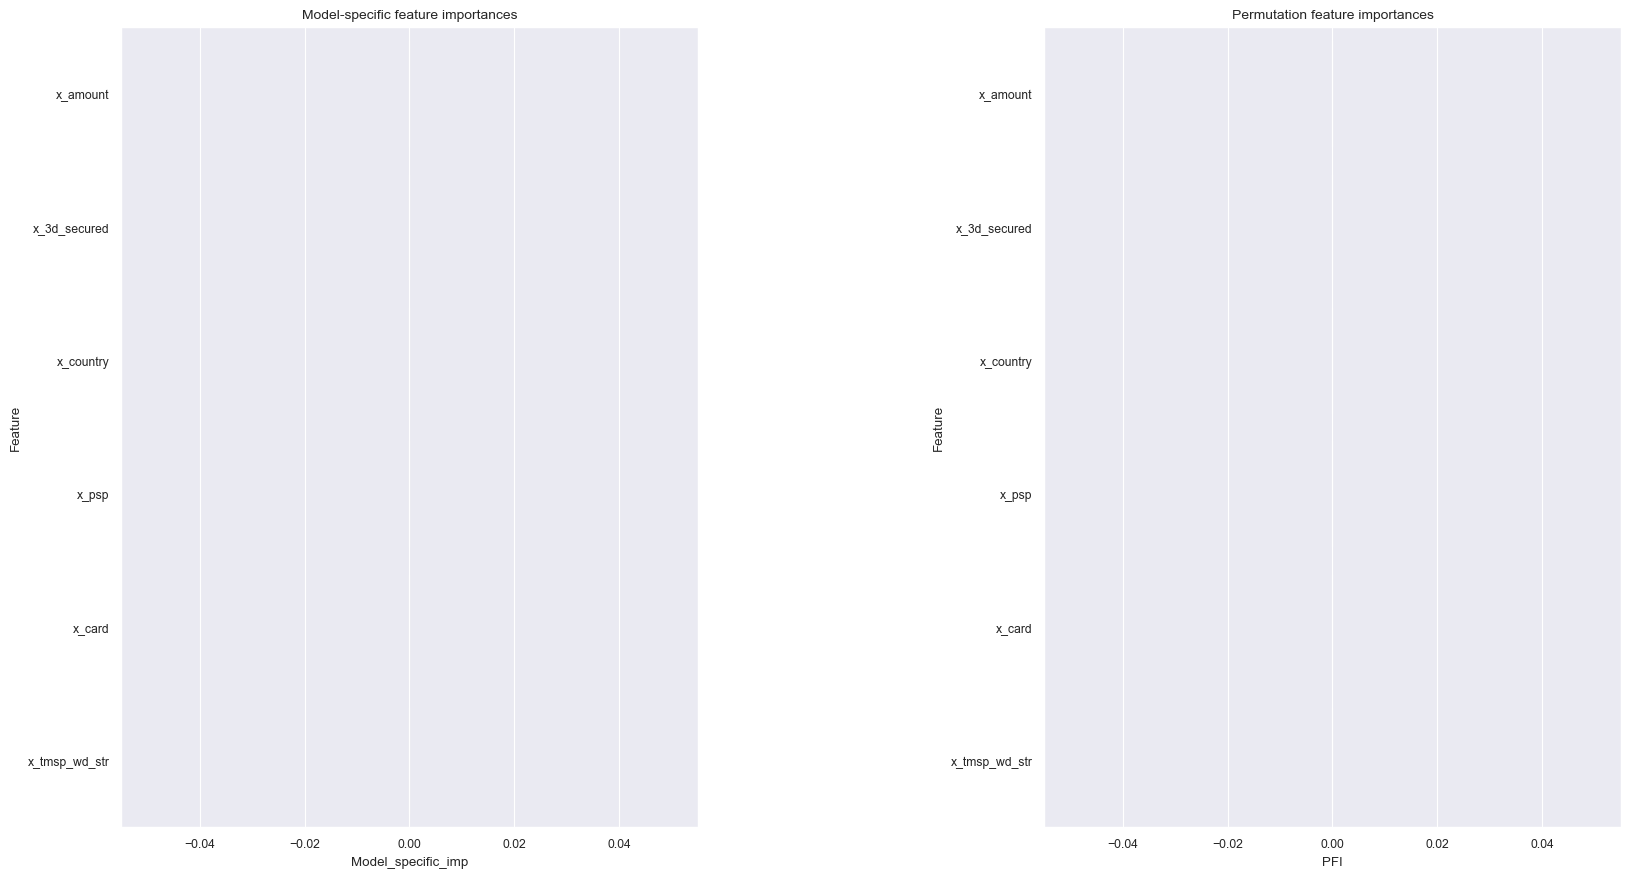

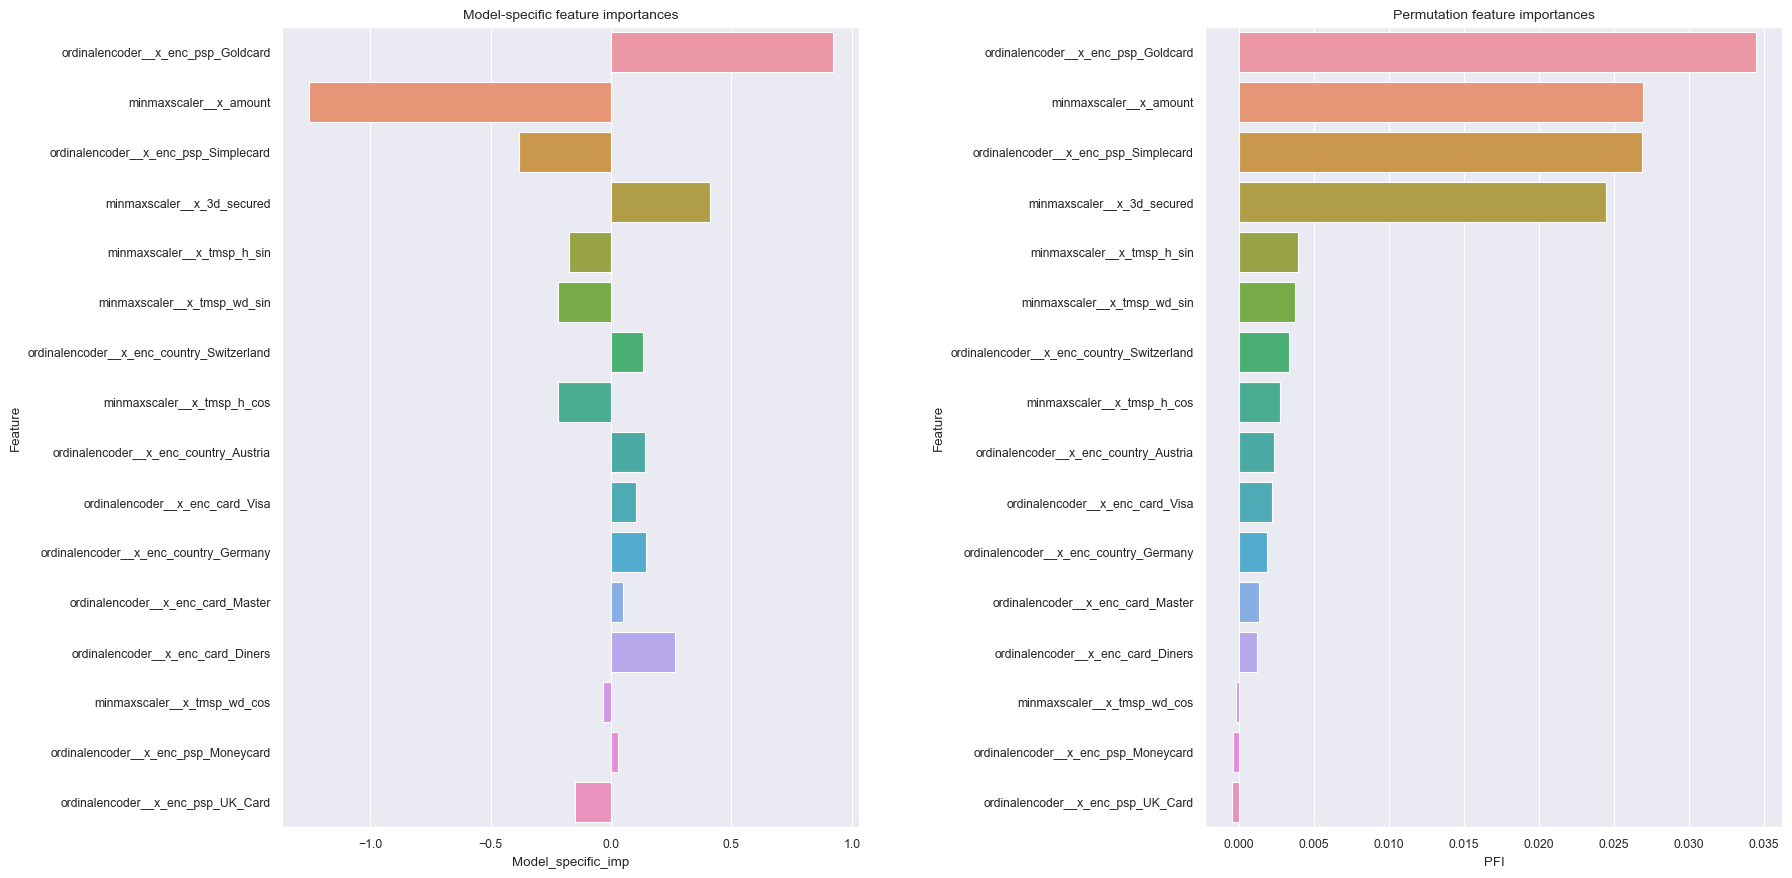

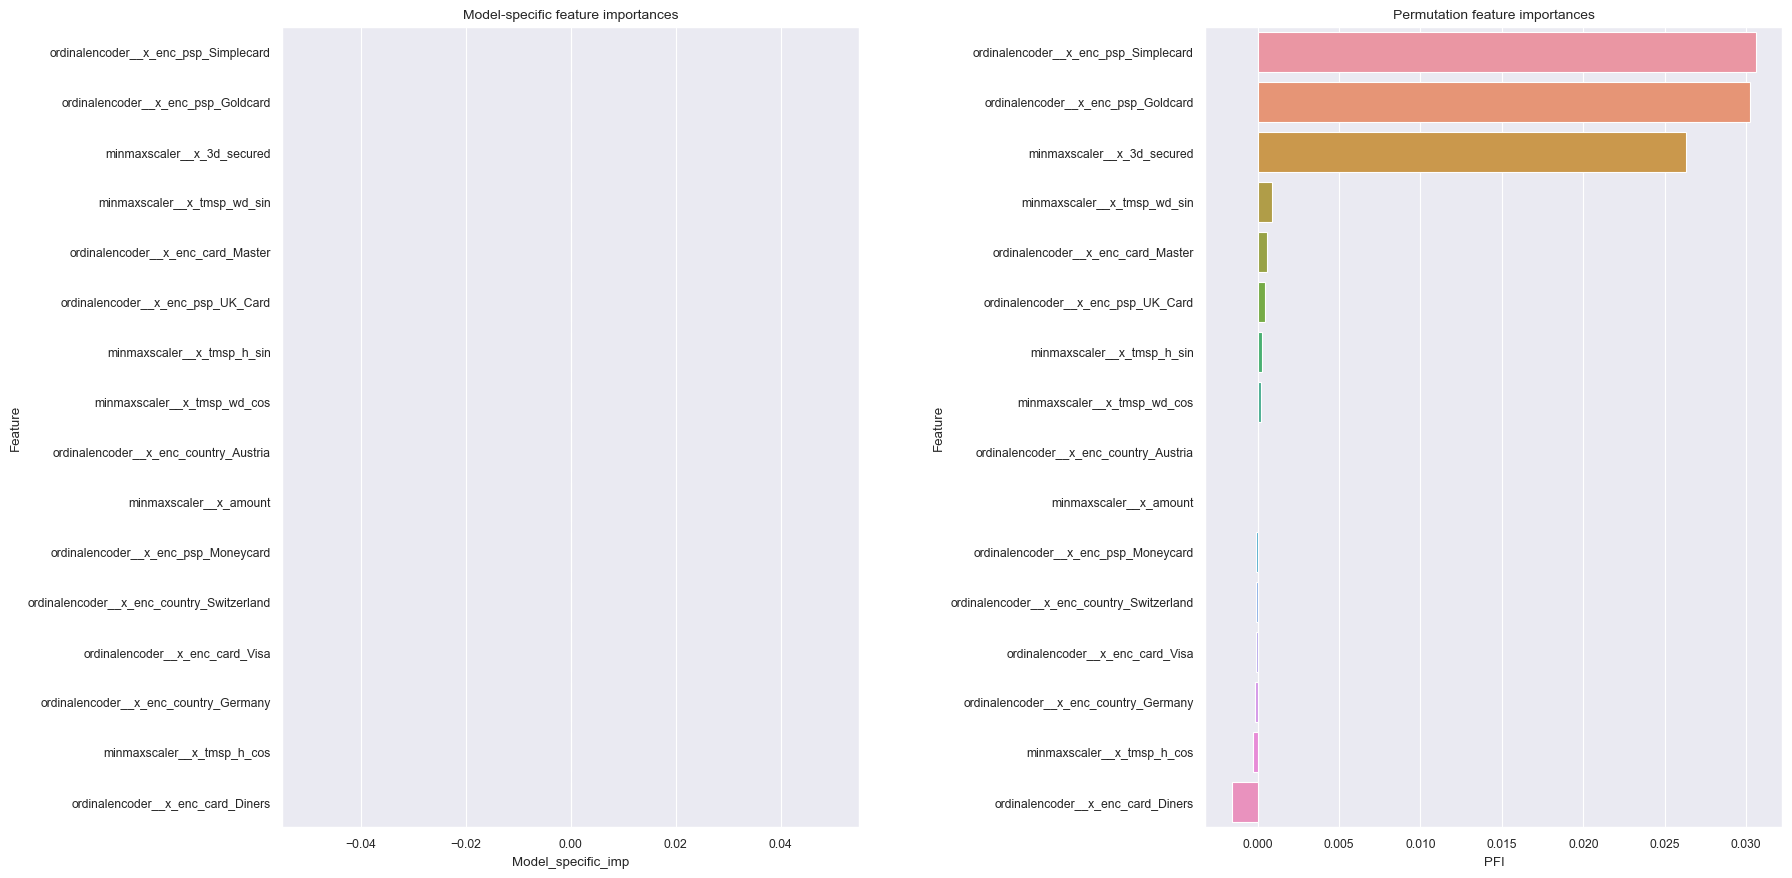

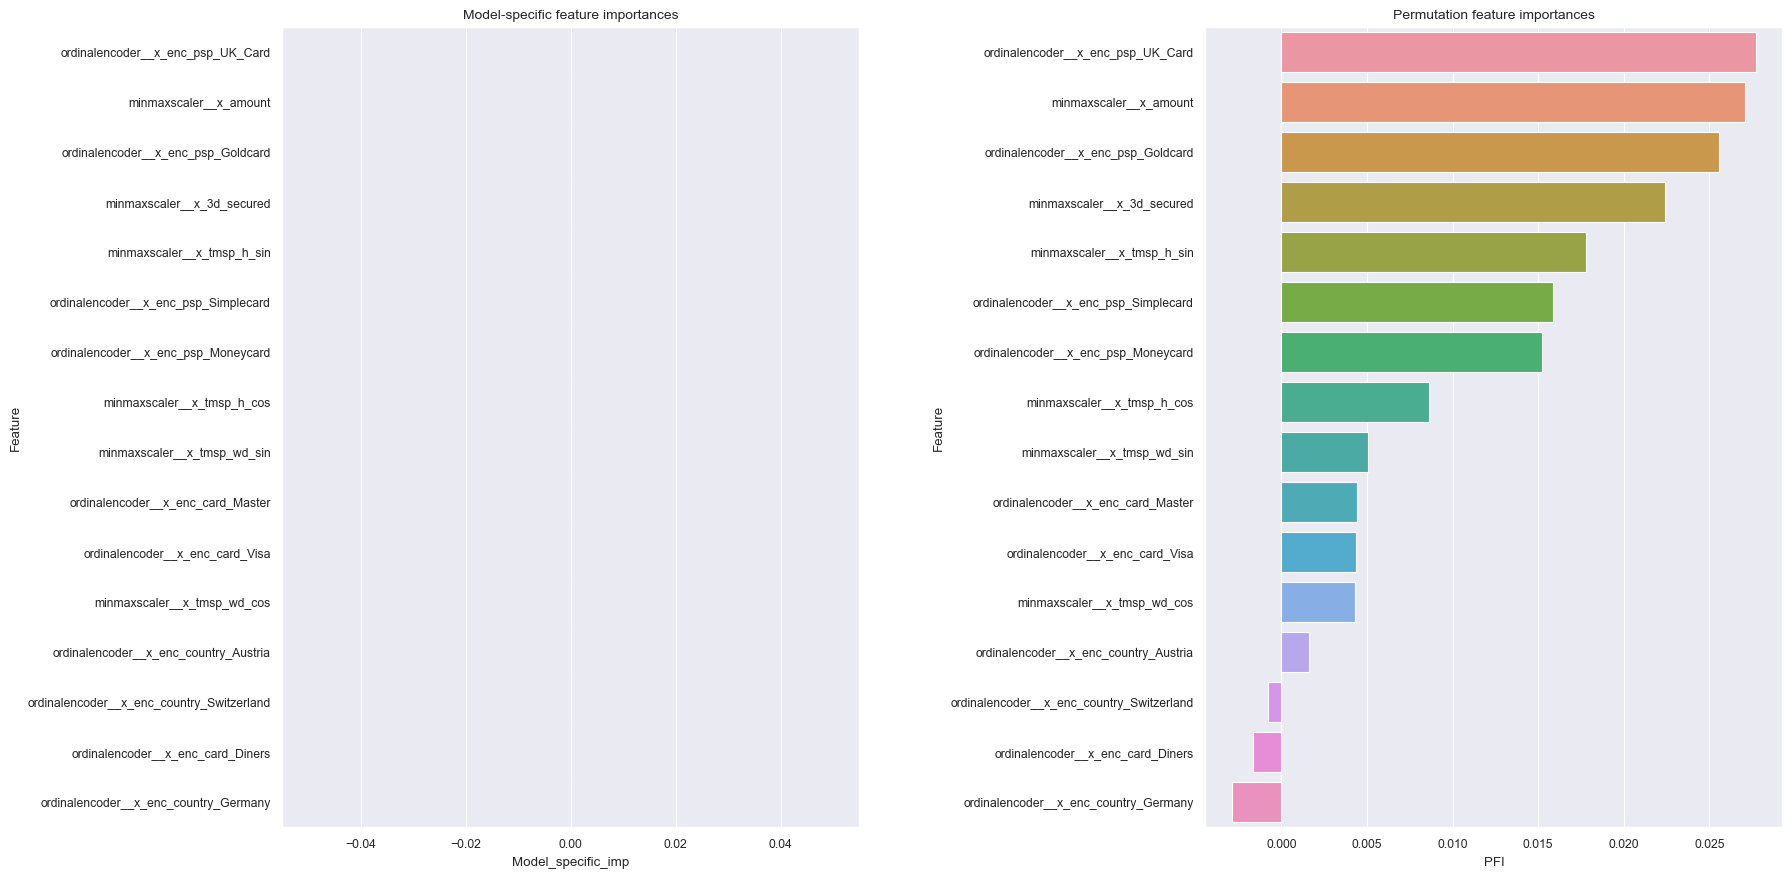

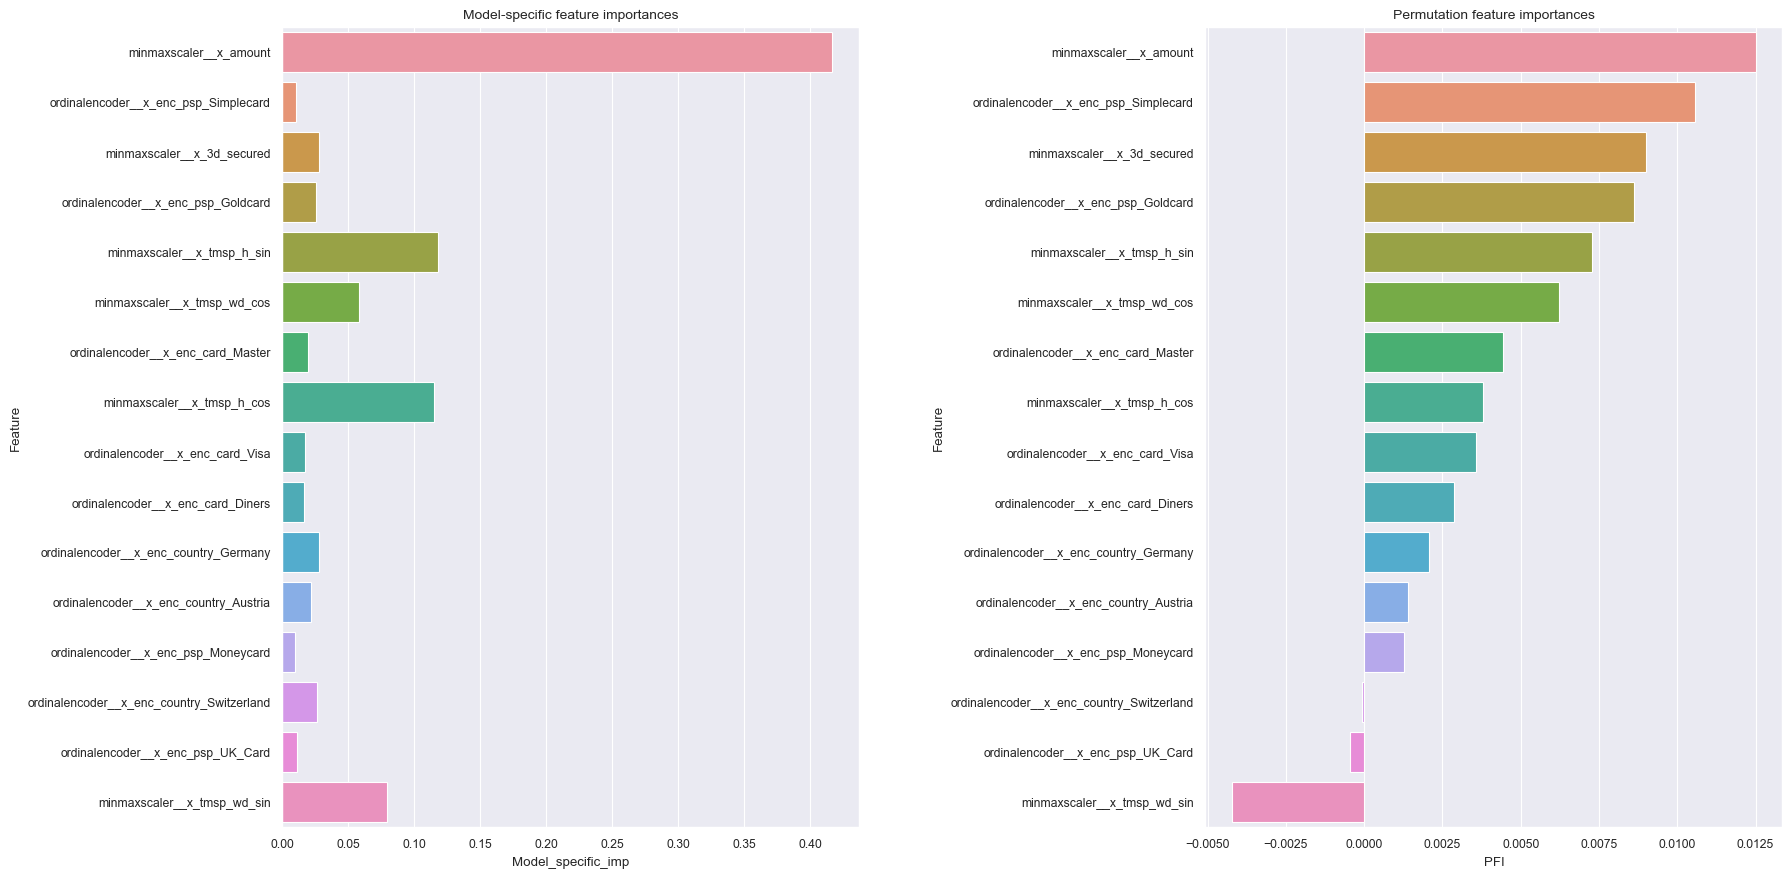

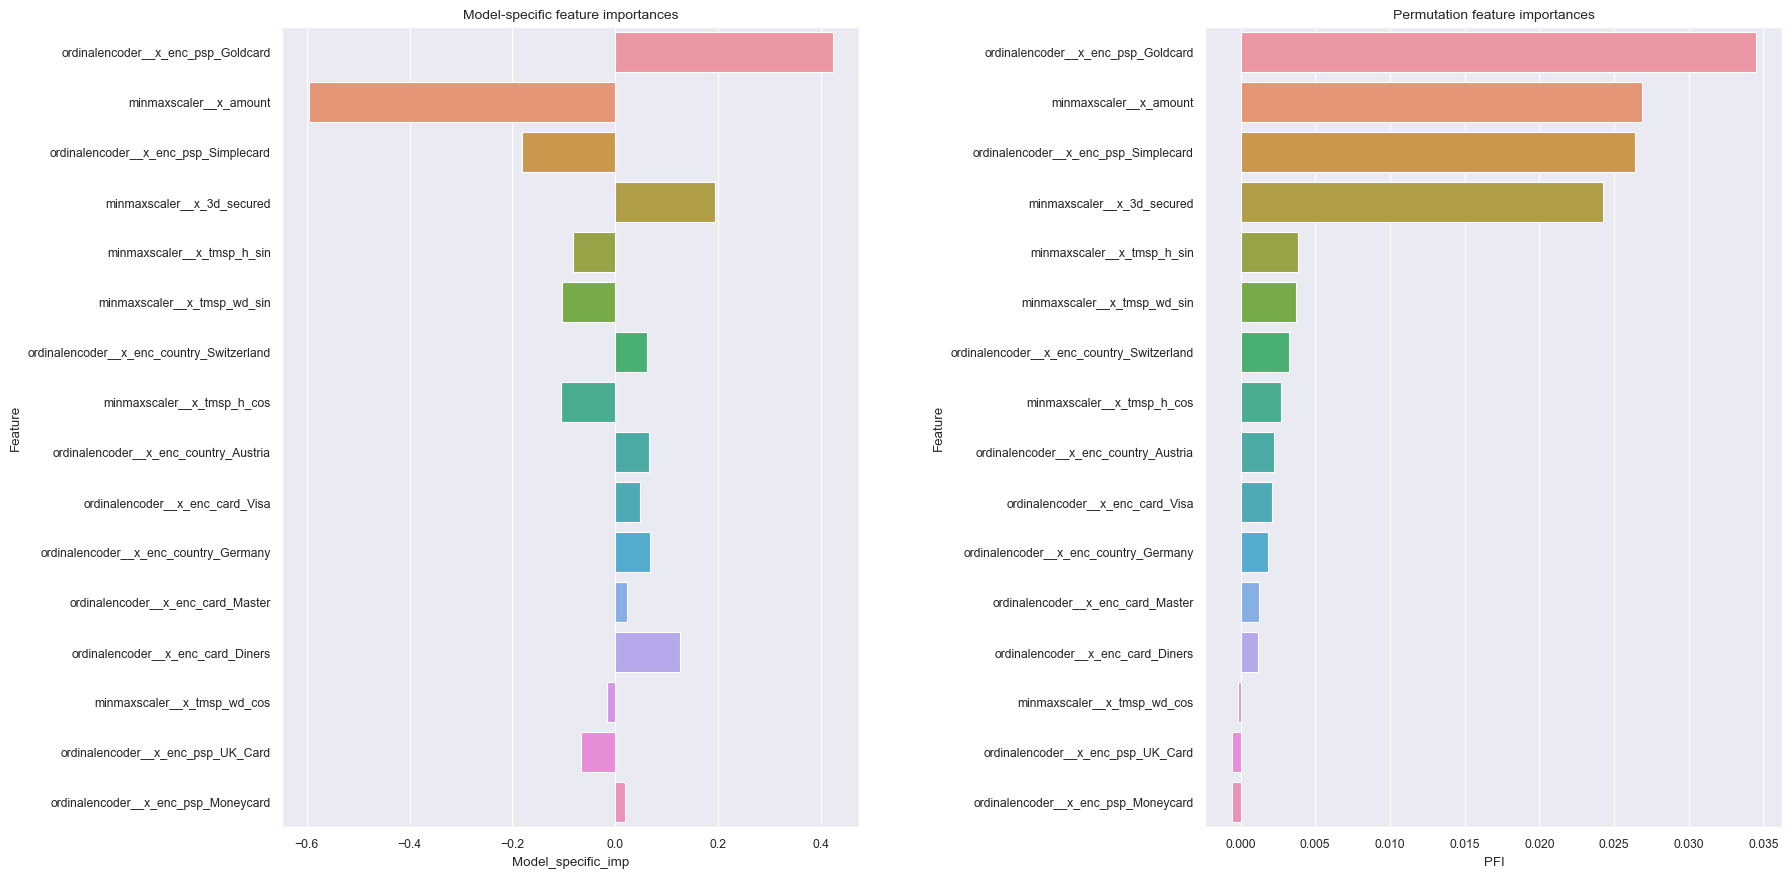

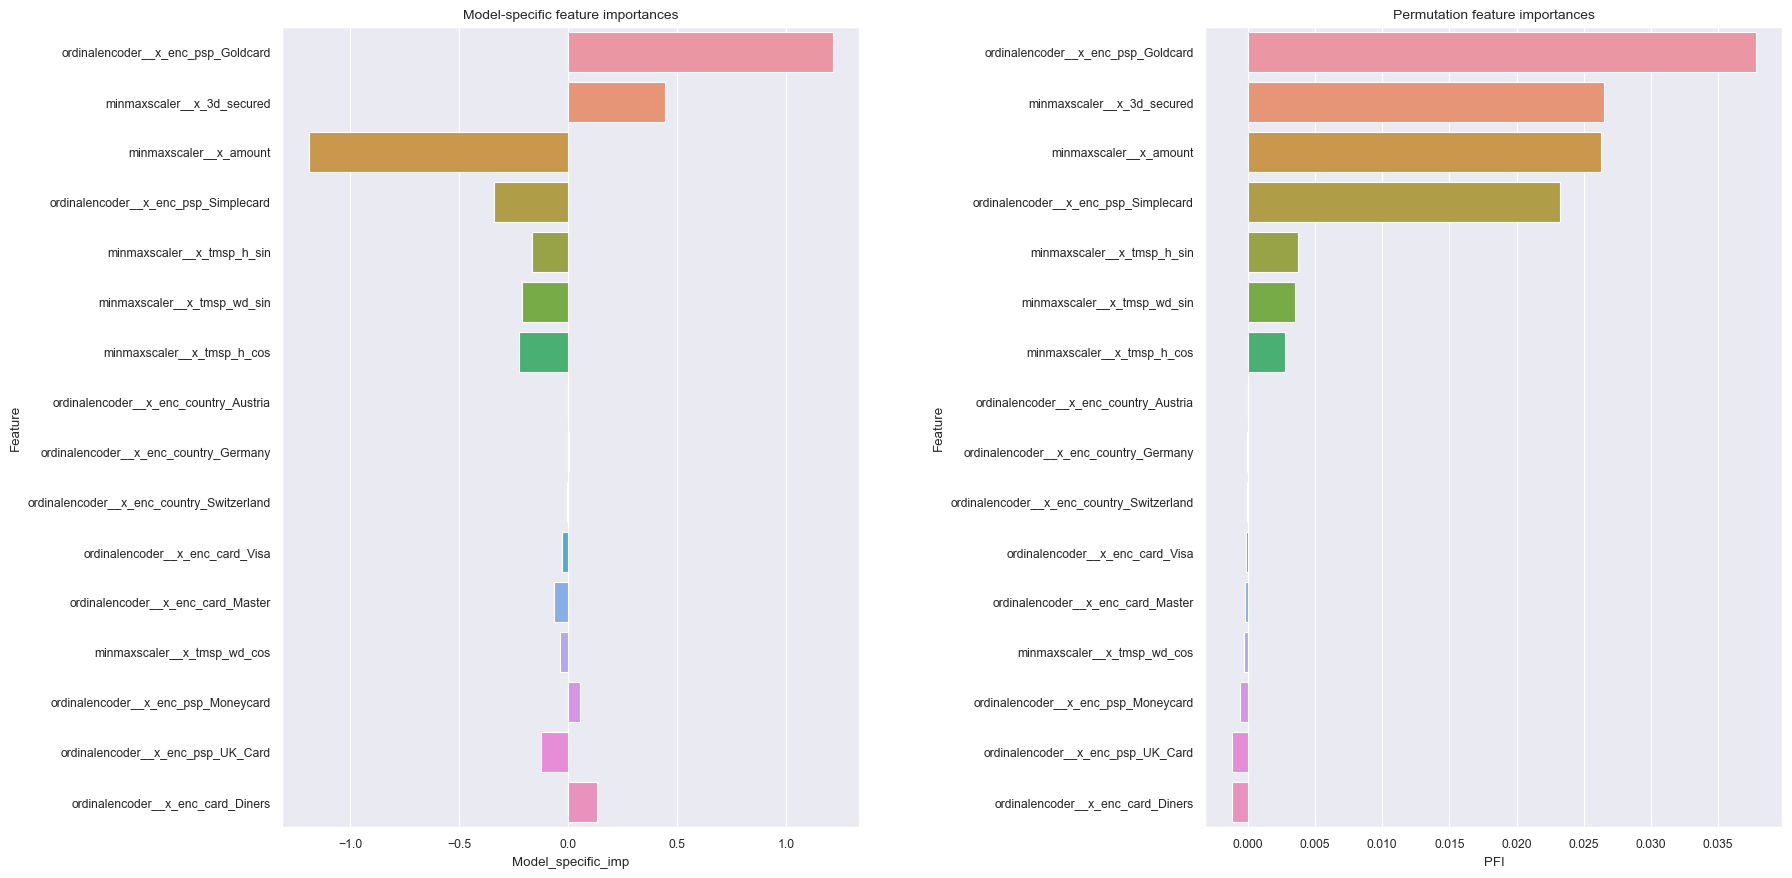

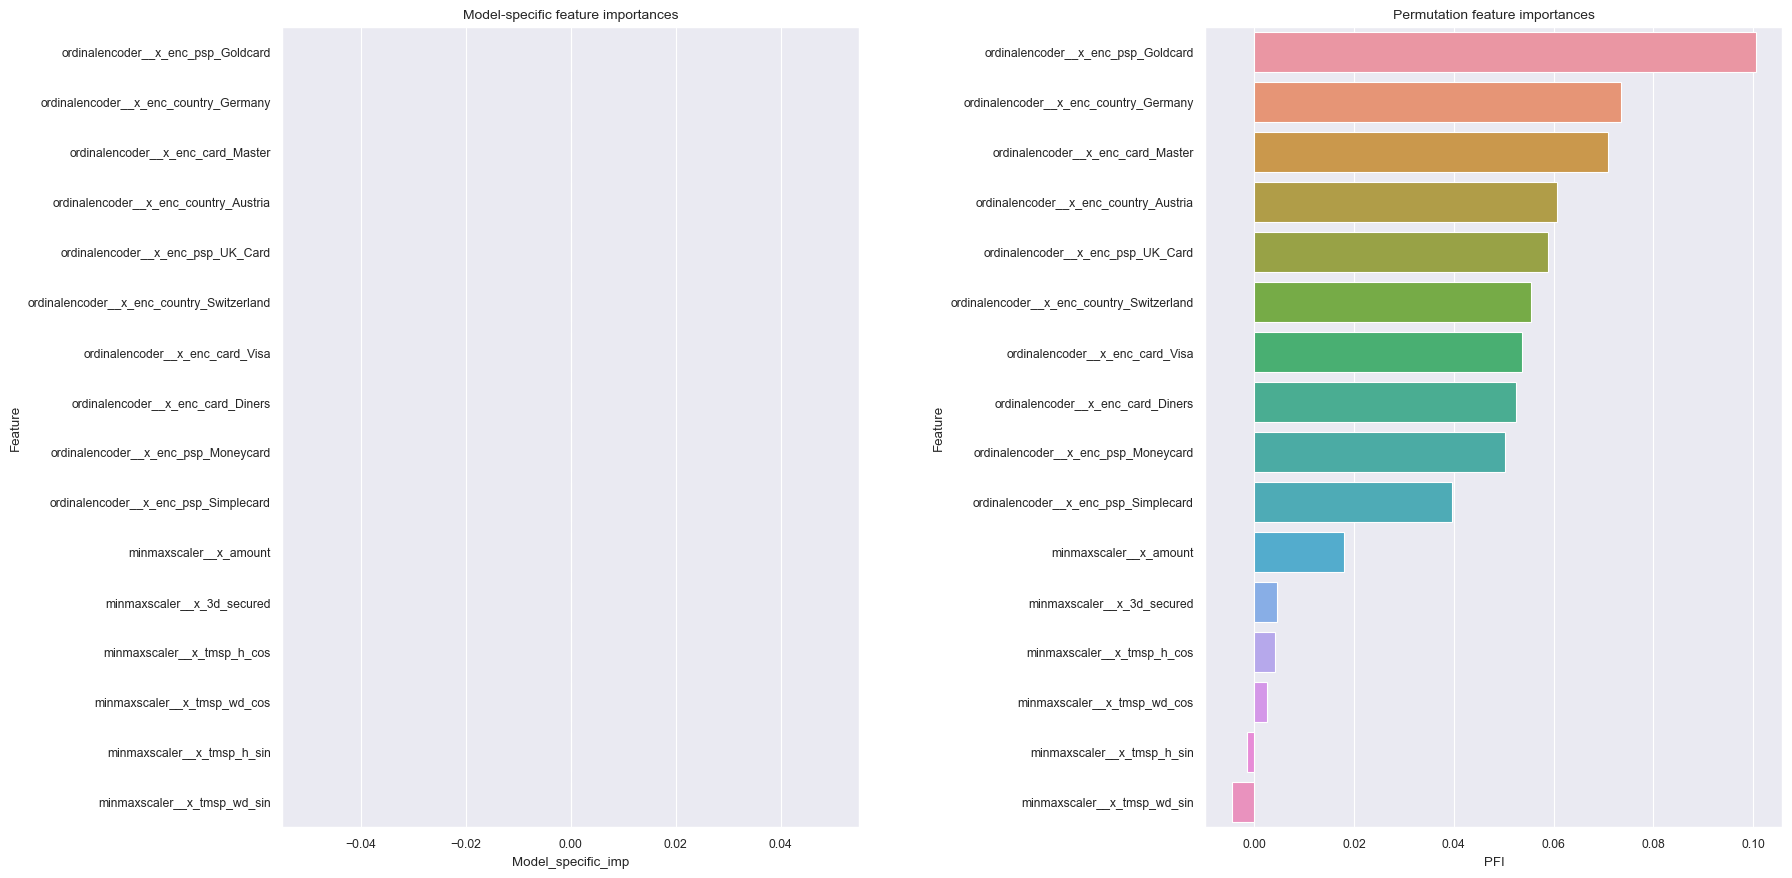

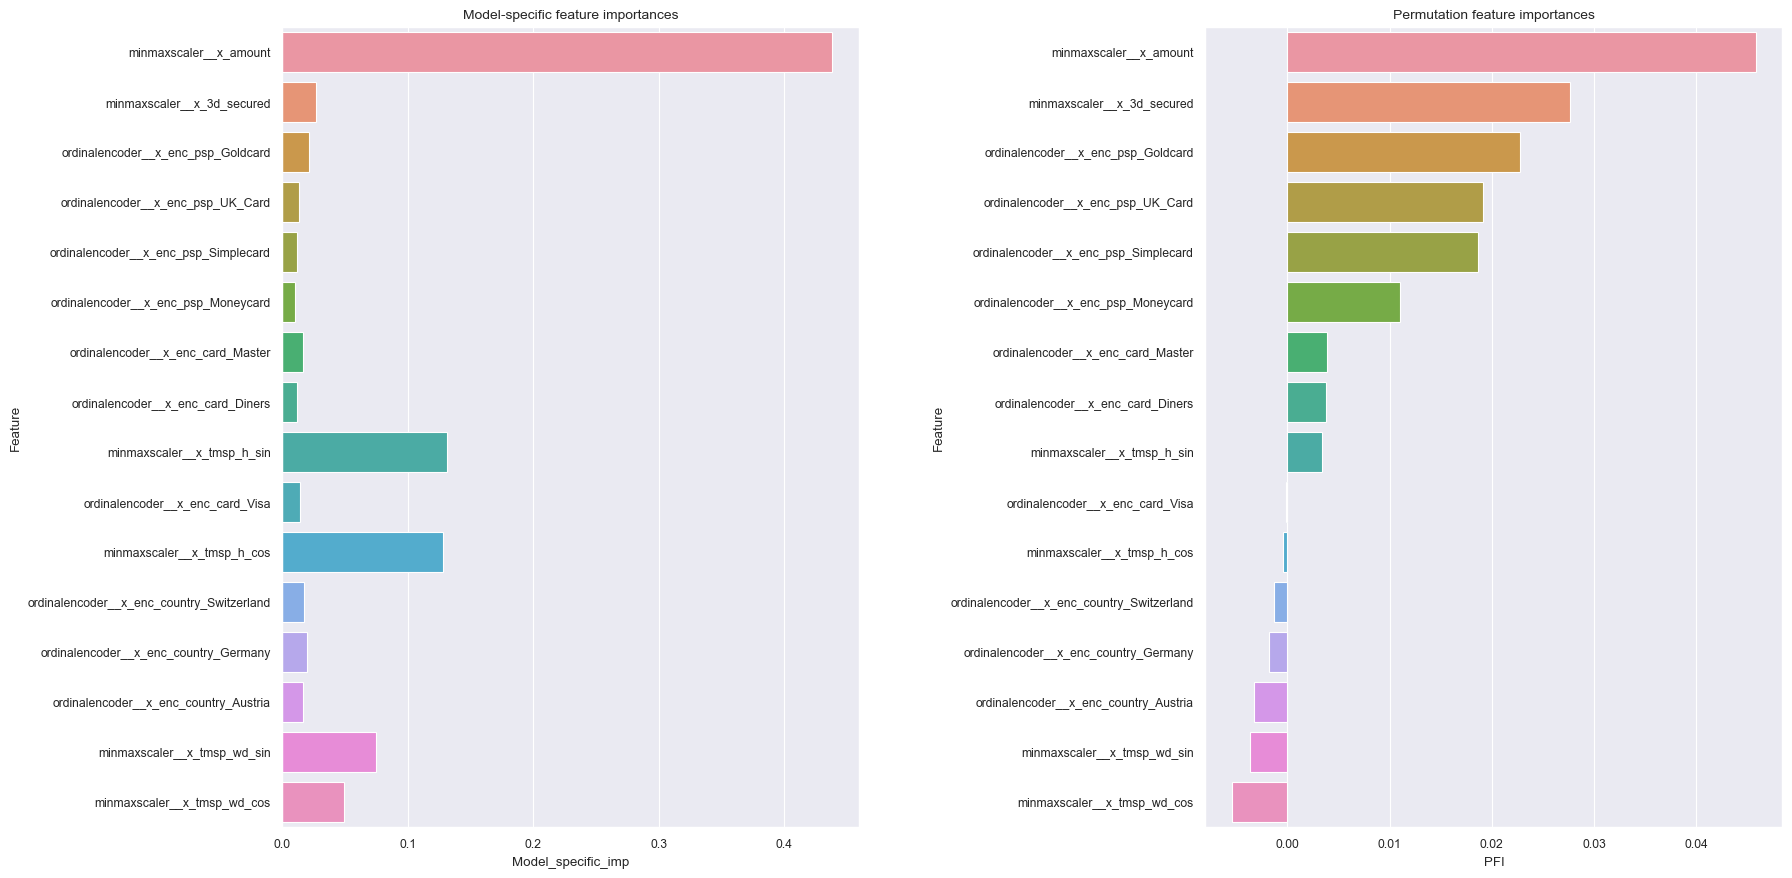

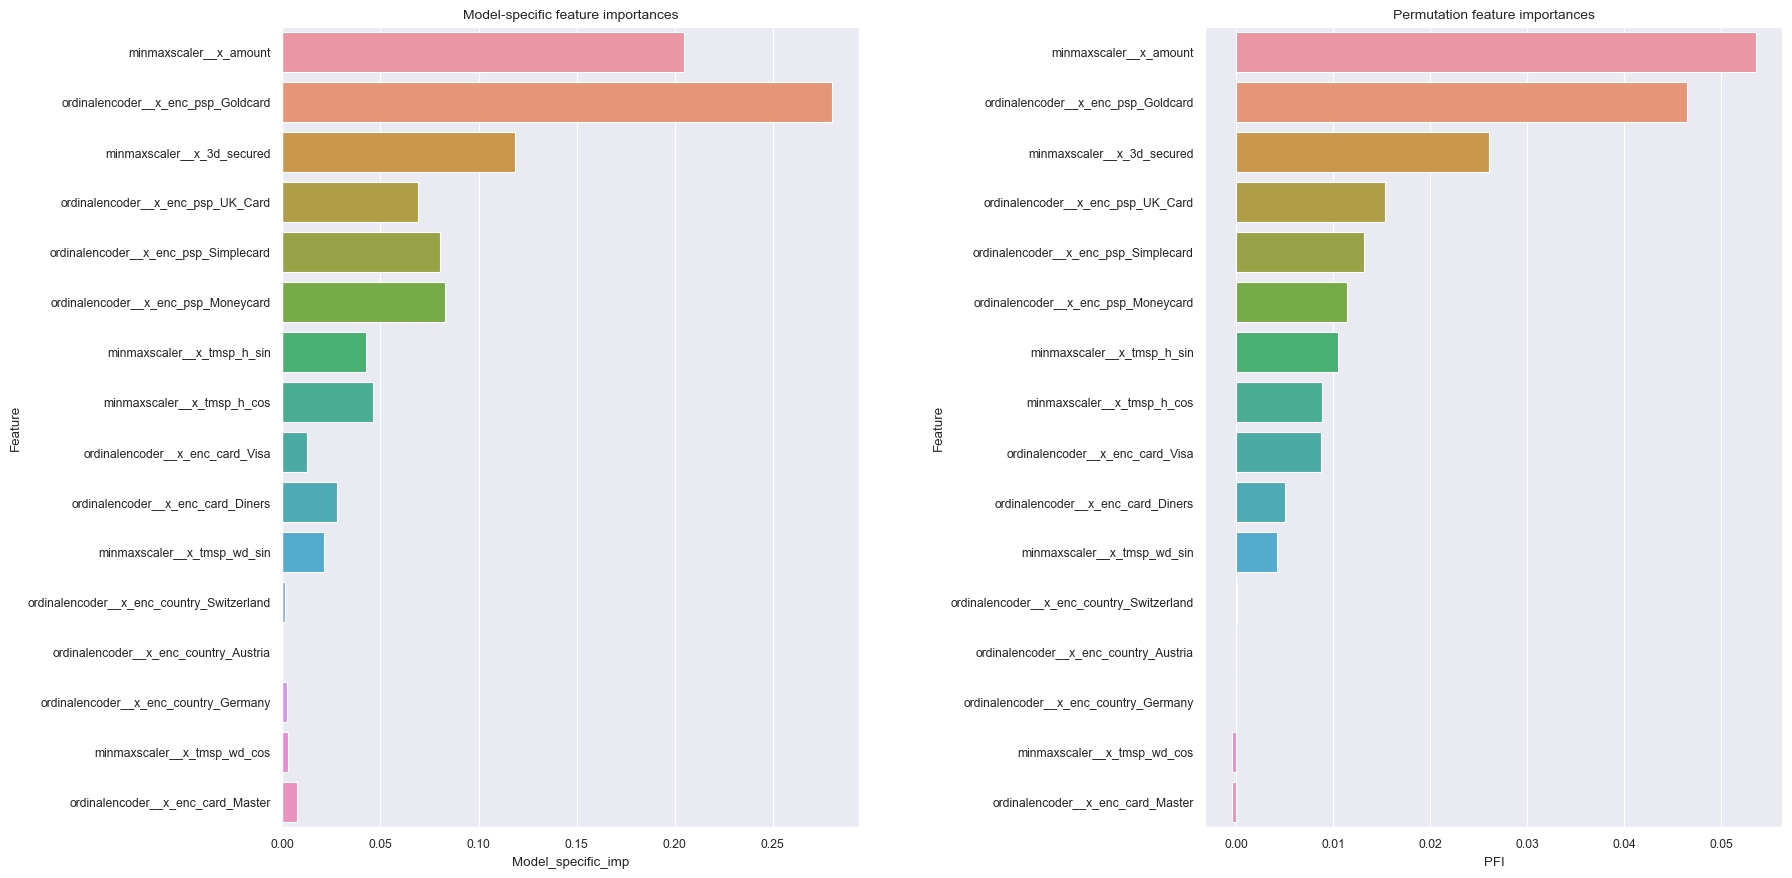

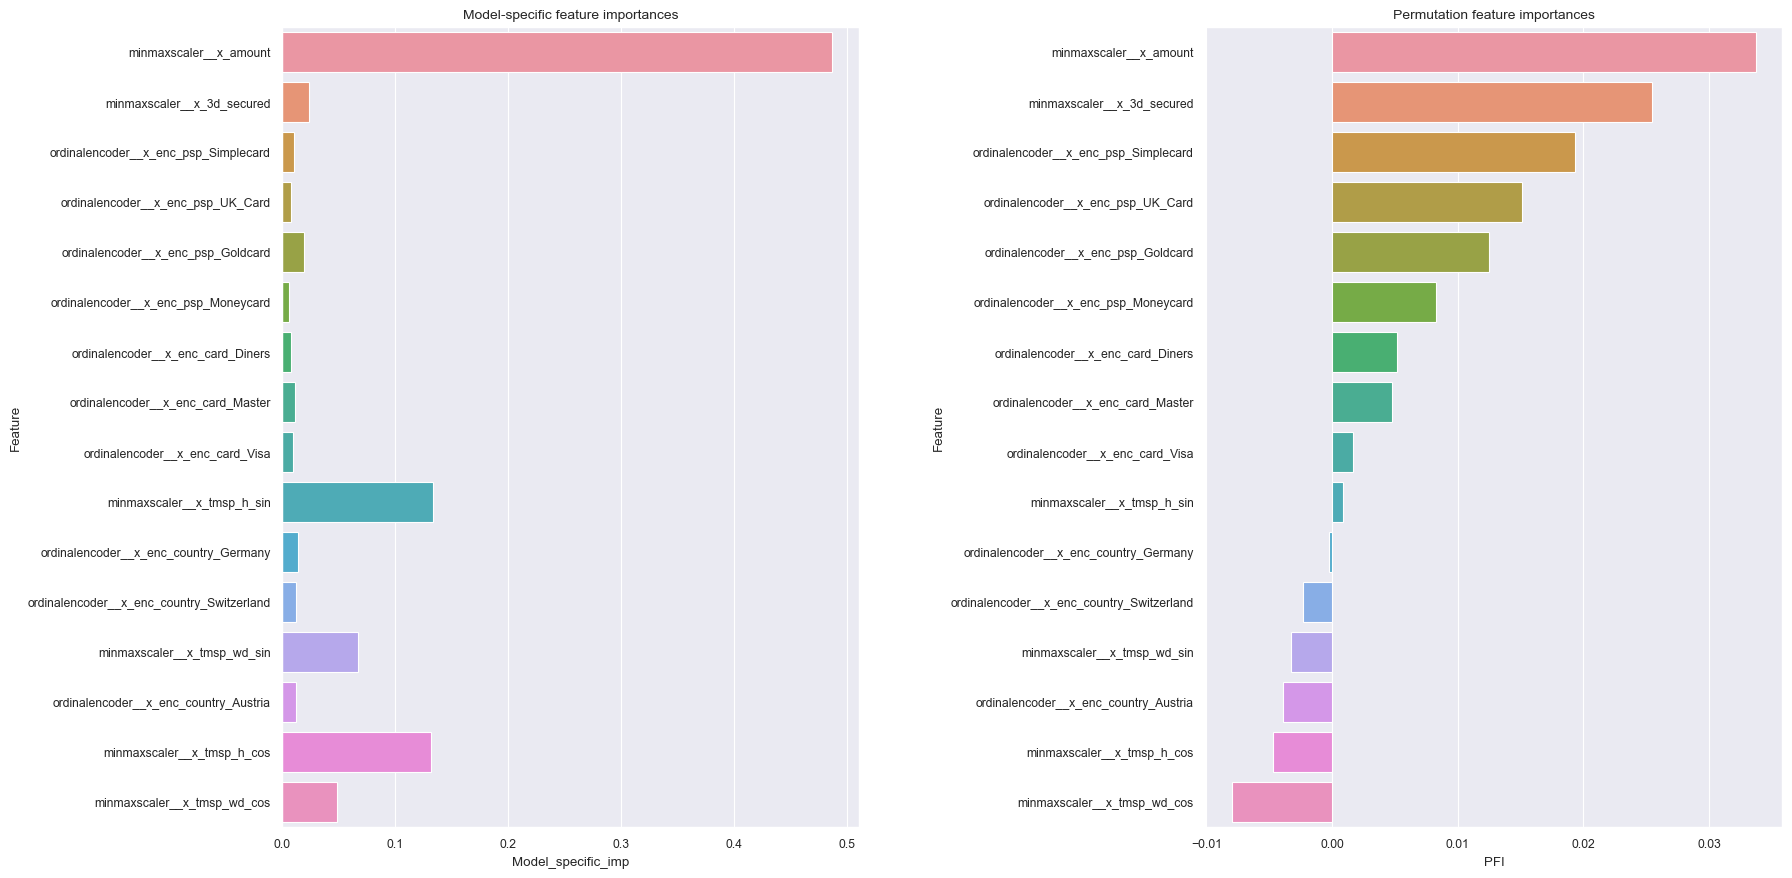

In [21]:
first_exp = "PSP_1b_w/_class_weights"
first_info = "1. Training for comparison of models WITH hyperparameter tuning"
"""train_model(zip_iter=first_step_zip, 
            x_train_raw=x_train_raw, x_train_numerical=x_train_numerical, 
            x_test_raw=x_test_raw, x_test_numerical=x_test_numerical, 
            y_train=y_train, y_test=y_test,
            features_numerical=transformed_features, 
            exp_name=first_exp, info_text=first_info, 
            rs=rs)"""

## Evaluate & understand 1st model training

Features with lowest performance:
- Country: Austria, Germany, Switzerland
- Working day

# Modeling no. 2: Remove least important features and models with lowest performance

## Drop features

In [22]:
# LIGHT set for raw features
x_train_raw_light = x_train_raw.drop(columns=["x_tmsp_wd_str", "x_country"])
x_test_raw_light = x_test_raw.drop(columns=["x_tmsp_wd_str", "x_country"])

In [23]:
# columns to remove in numerical input
index_to_drop = [list(transformed_features).index(i) for i in transformed_features if (i.find("_country_")!=-1) or (i.find("_wd_")!=-1)]

# LIGHT set for model with numerical input
features_light = np.delete(transformed_features, index_to_drop, 0)
x_train_numerical_light = np.delete(x_train_numerical, index_to_drop, 1)
x_test_numerical_light = np.delete(x_test_numerical, index_to_drop, 1)

## Training of models

In [24]:
# collect all models
# names
second_step_clf_names = ["Baseline model stratified", 
                        "Logistic Regression", 
                        "Naive Bayes", 
                        "KNN", 
                        "Decision Tree", 
                        "Linear SVM",   
                        "LDA", 
                        "QDA",
                        "Random Forest", 
                        "Gradient Boosting", 
                        "Extra Trees"]

# sklearn models
second_step_clf = [DummyClassifier(strategy="stratified", **params_rs), 
                  LogisticRegression(class_weight="balanced", penalty=None, **params_rs), 
                  CategoricalNB(), 
                  KNeighborsClassifier(), 
                  DecisionTreeClassifier(class_weight="balanced", **params_rs),
                  LinearSVC(class_weight="balanced", **params_rs),
                  LinearDiscriminantAnalysis(), 
                  QuadraticDiscriminantAnalysis(),
                  RandomForestClassifier(class_weight="balanced_subsample", **params_rs), 
                  GradientBoostingClassifier(**params_rs), 
                  ExtraTreesClassifier(class_weight="balanced_subsample", **params_rs)]

# feature mode for model
second_step_feat_mode = ["raw", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric"]

second_step_zip = zip(second_step_clf_names, second_step_clf, second_step_feat_mode)
print(f"length of clf_names {len(second_step_clf_names)} & clf {len(second_step_clf)} & feat_mode {len(second_step_feat_mode)}")

length of clf_names 11 & clf 11 & feat_mode 11


Training and logging of model Baseline model stratified as classifier DummyClassifier(random_state=23, strategy='stratified') with feature mode raw
Has NO feature importances
For Baseline model stratified: Run logged in MLflow with 6100dd447ad540228561e3dde1cb72d0.
---------------------- 

Training and logging of model Logistic Regression as classifier LogisticRegression(class_weight='balanced', penalty=None, random_state=23) with feature mode numeric
For Logistic Regression: Run logged in MLflow with 86e55bf087304eaf9a9187b58975dee5.
---------------------- 

Training and logging of model Naive Bayes as classifier CategoricalNB() with feature mode numeric
Has NO feature importances
For Naive Bayes: Run logged in MLflow with 42f6cdfe1d5240f58b6049bbd8bf39ef.
---------------------- 

Training and logging of model KNN as classifier KNeighborsClassifier() with feature mode numeric
Has NO feature importances
For KNN: Run logged in MLflow with 4780d066c2f54cd0aa66a5fad07d5828.
--------------

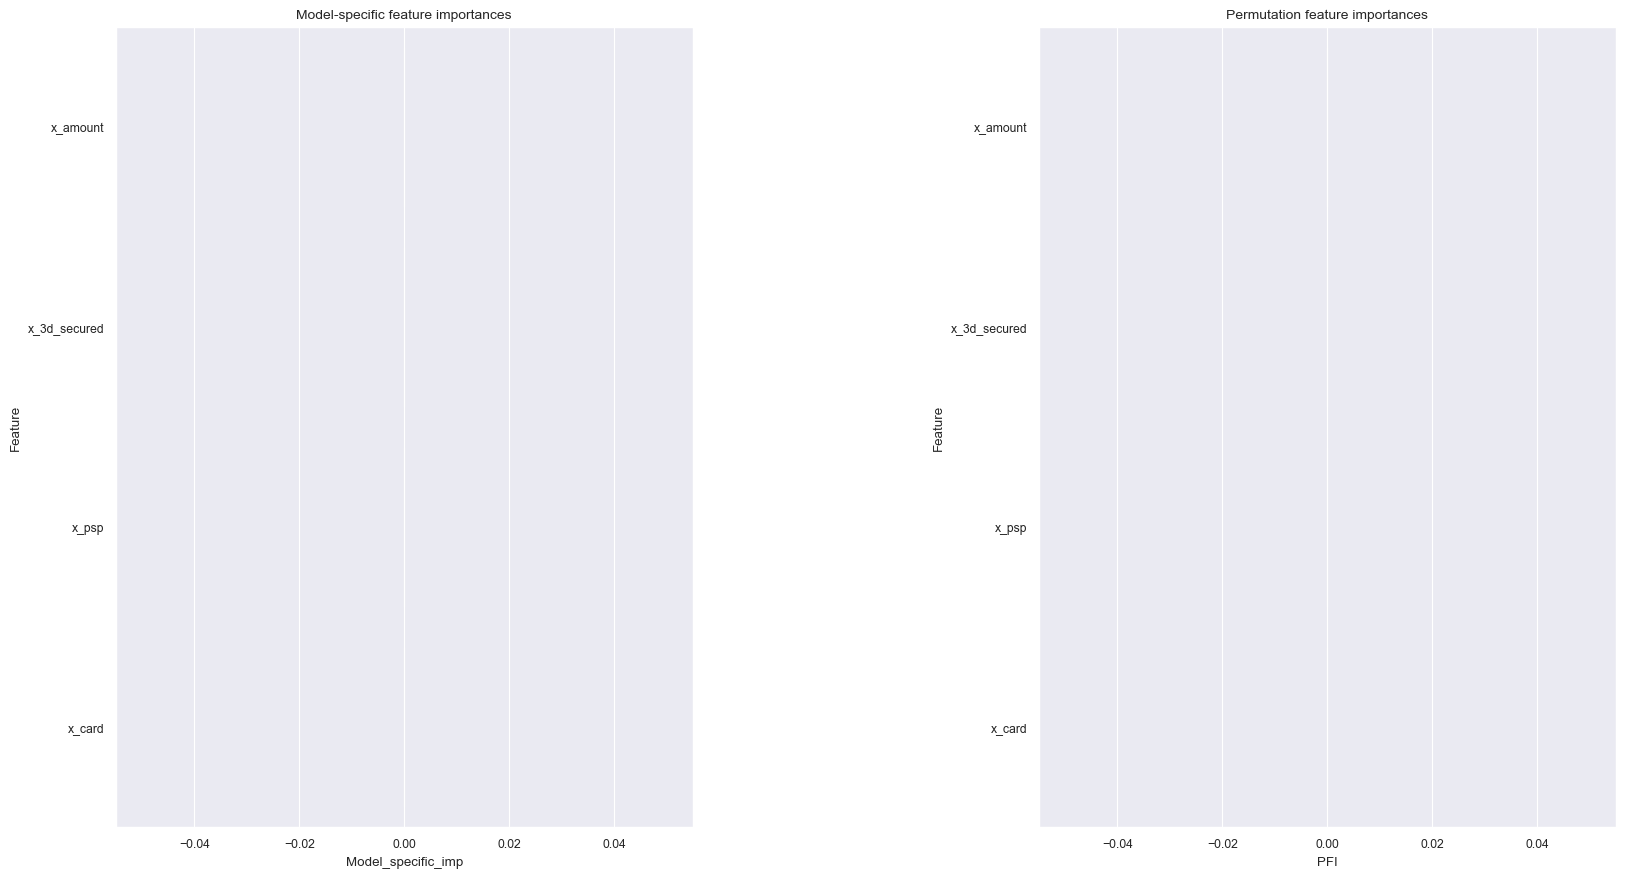

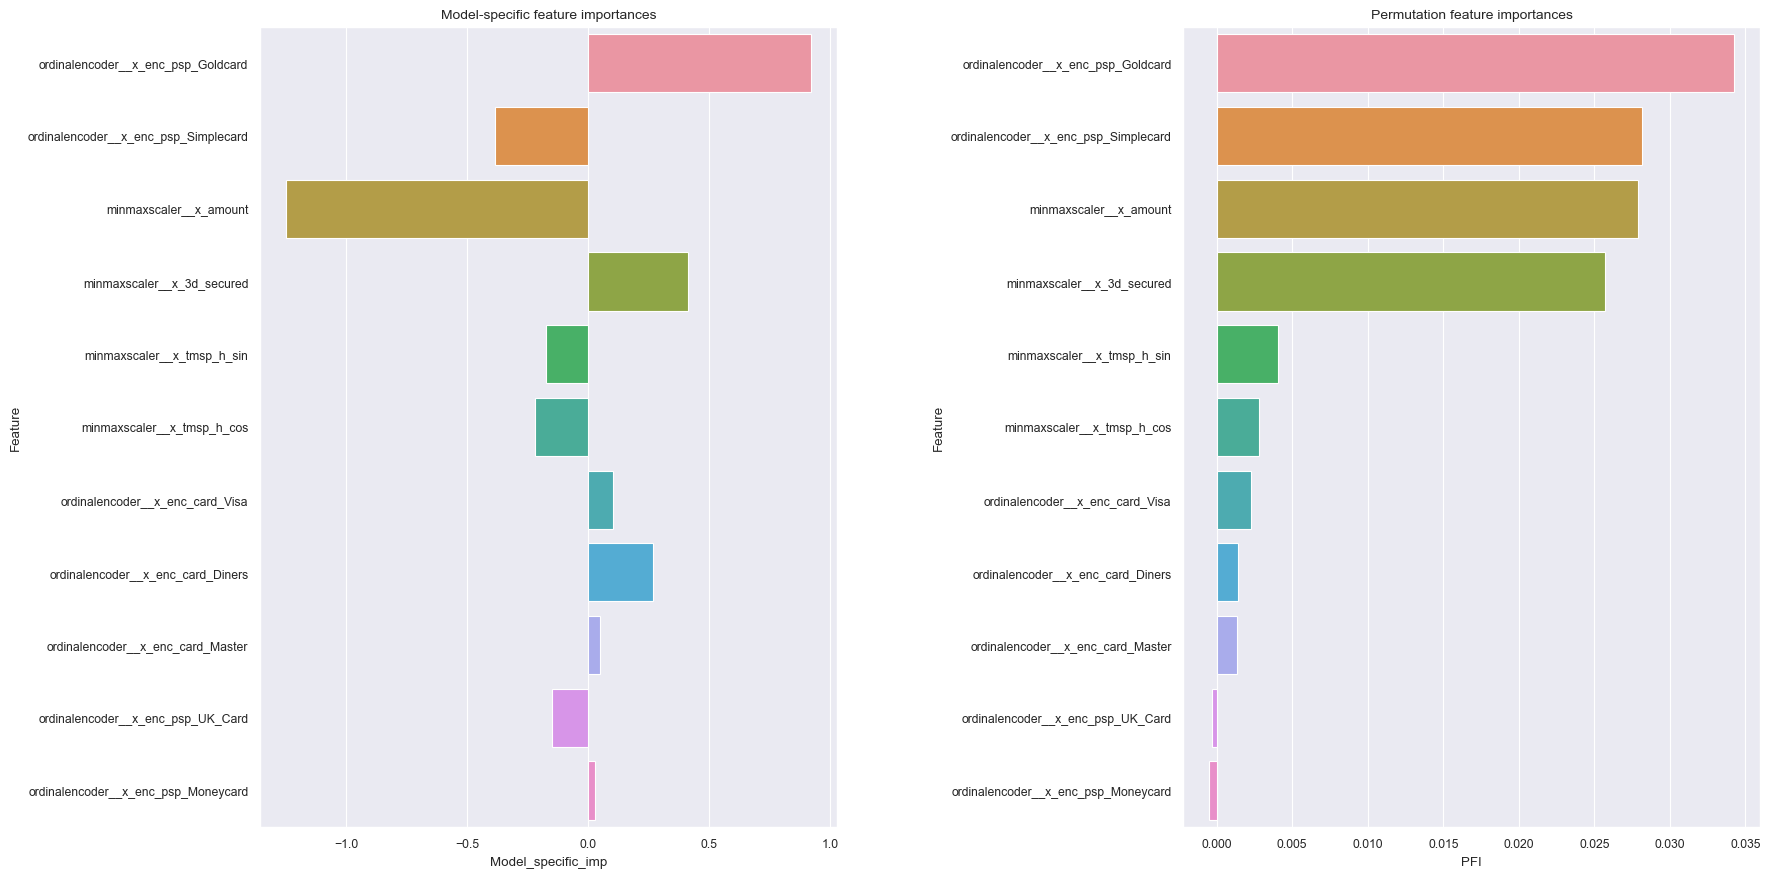

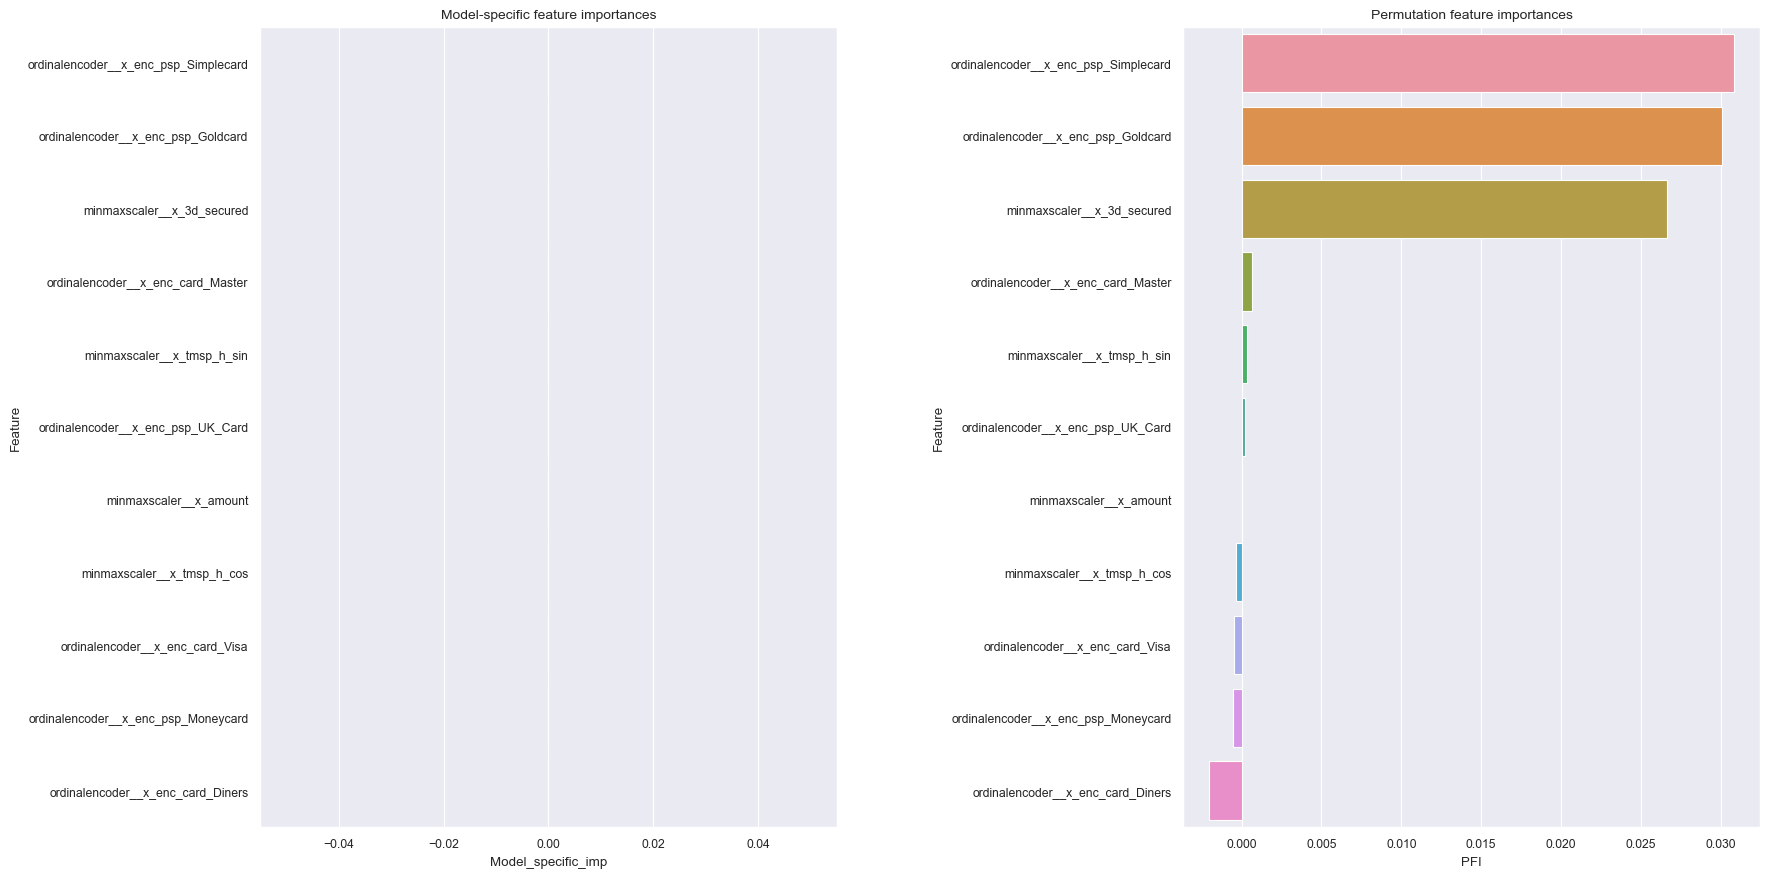

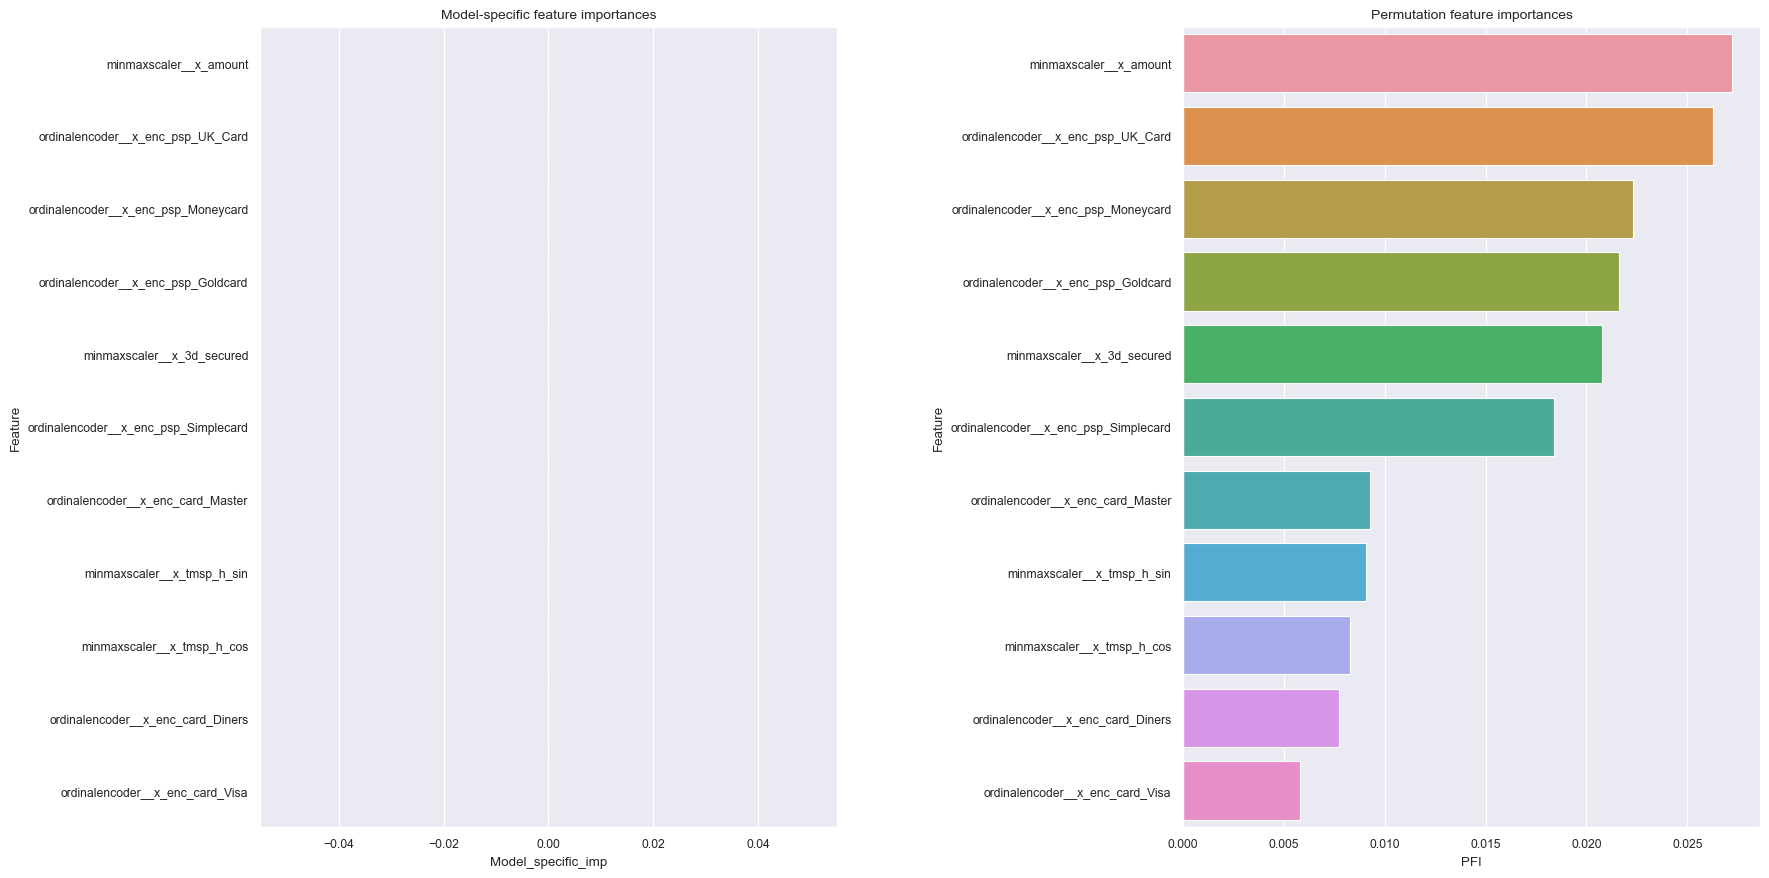

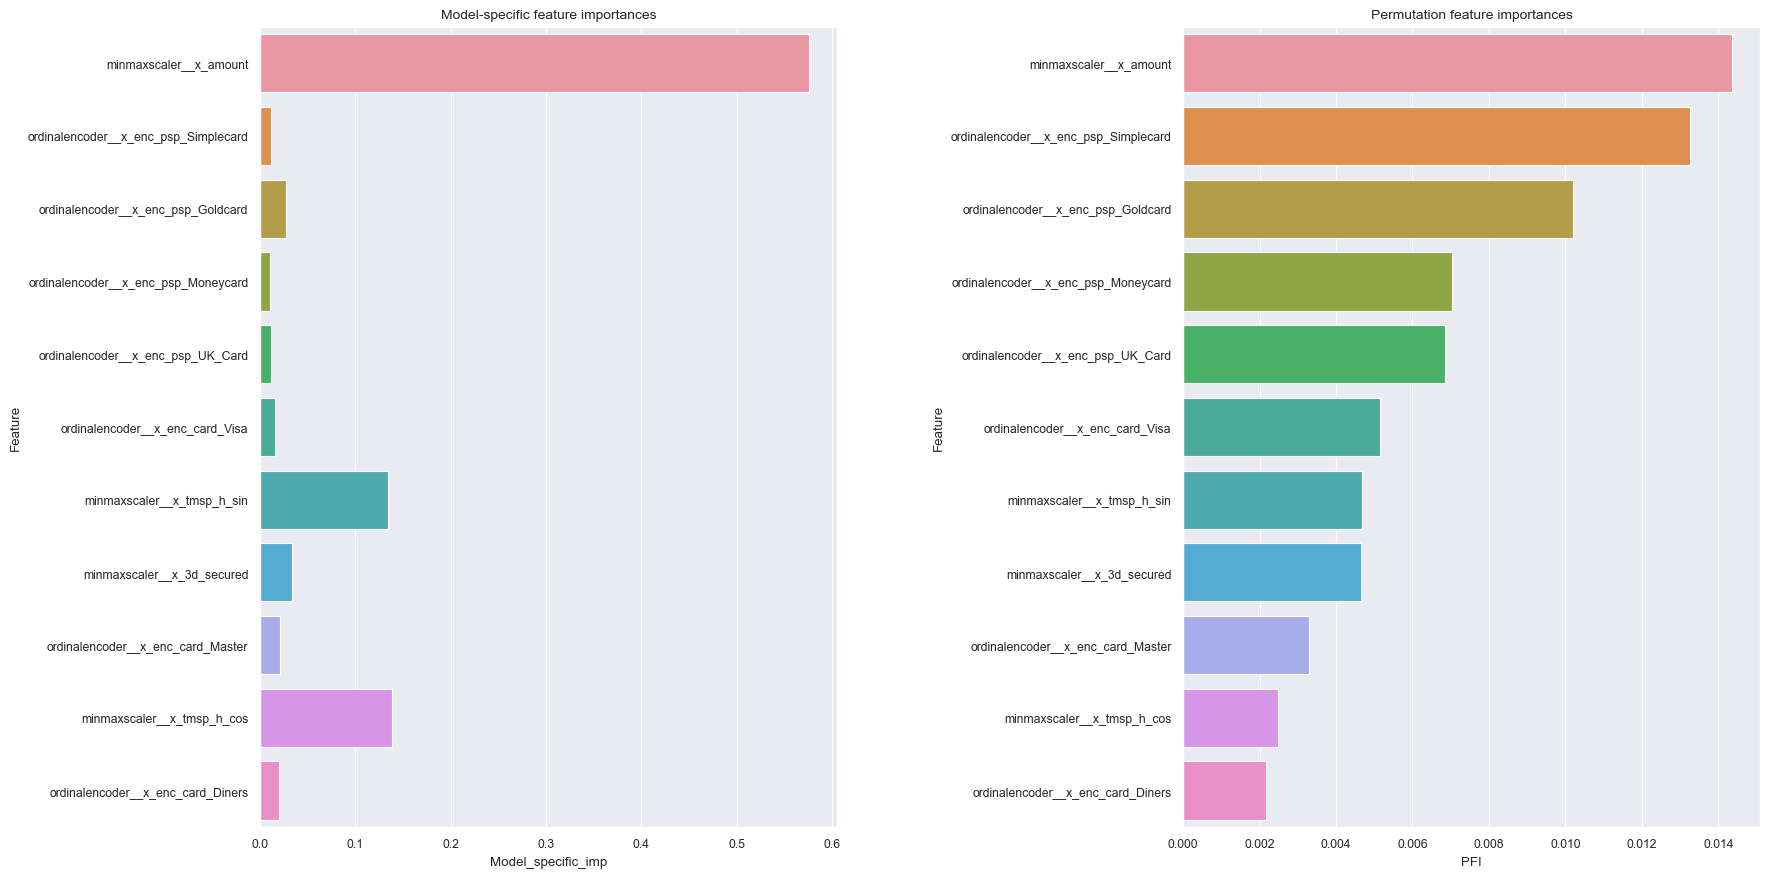

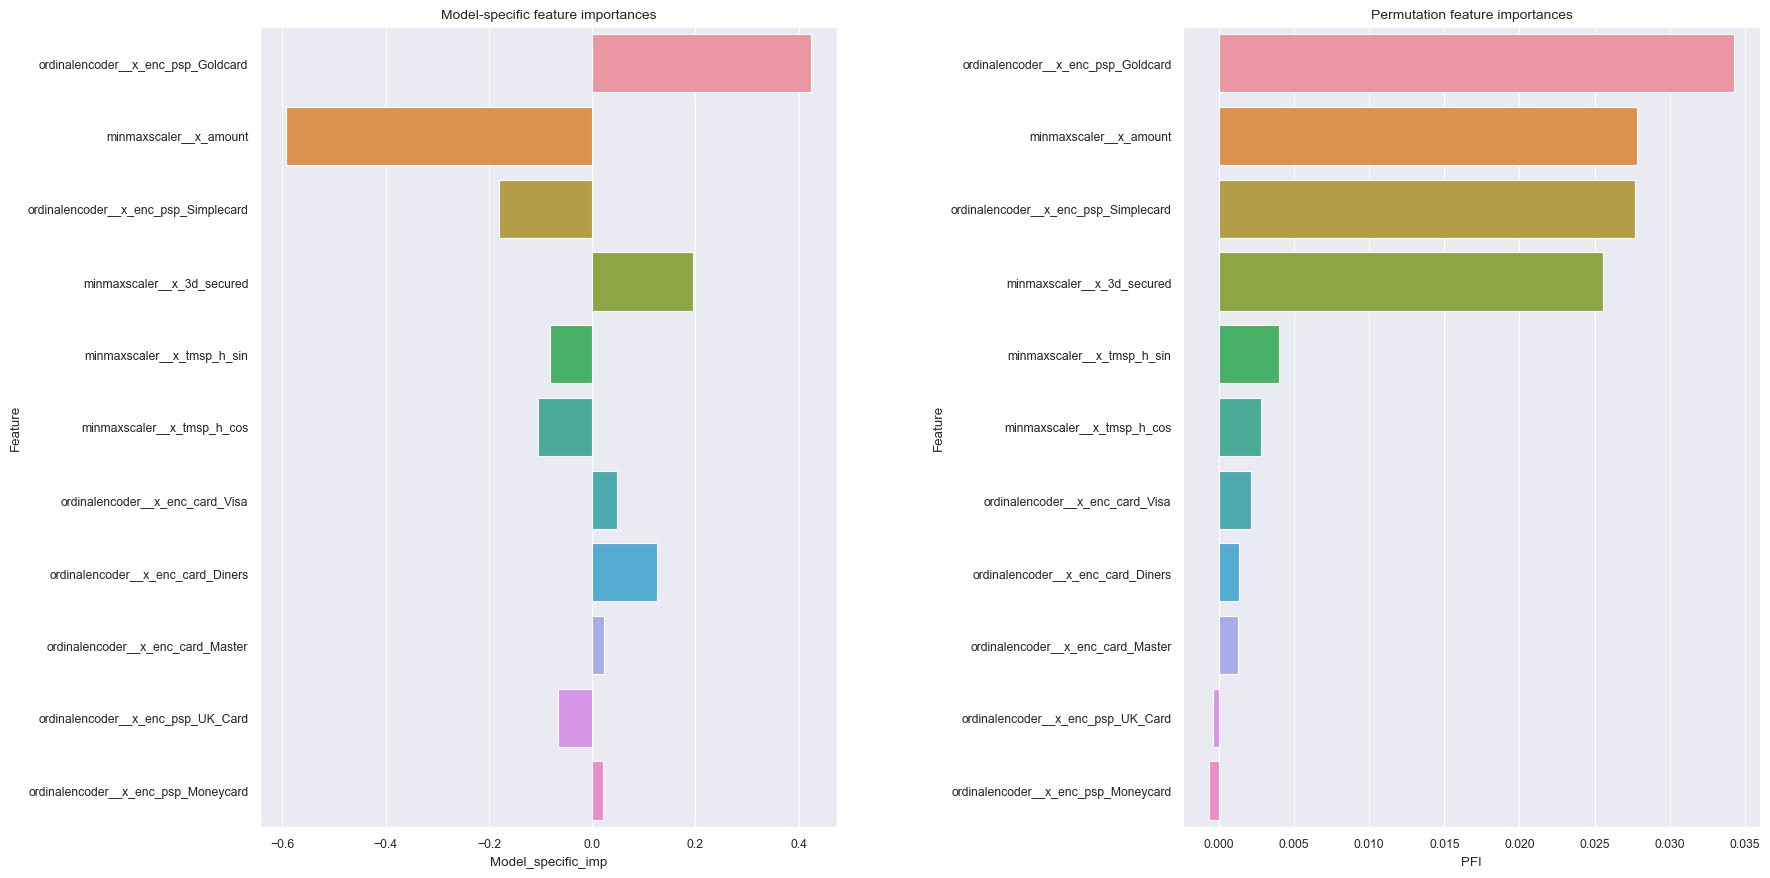

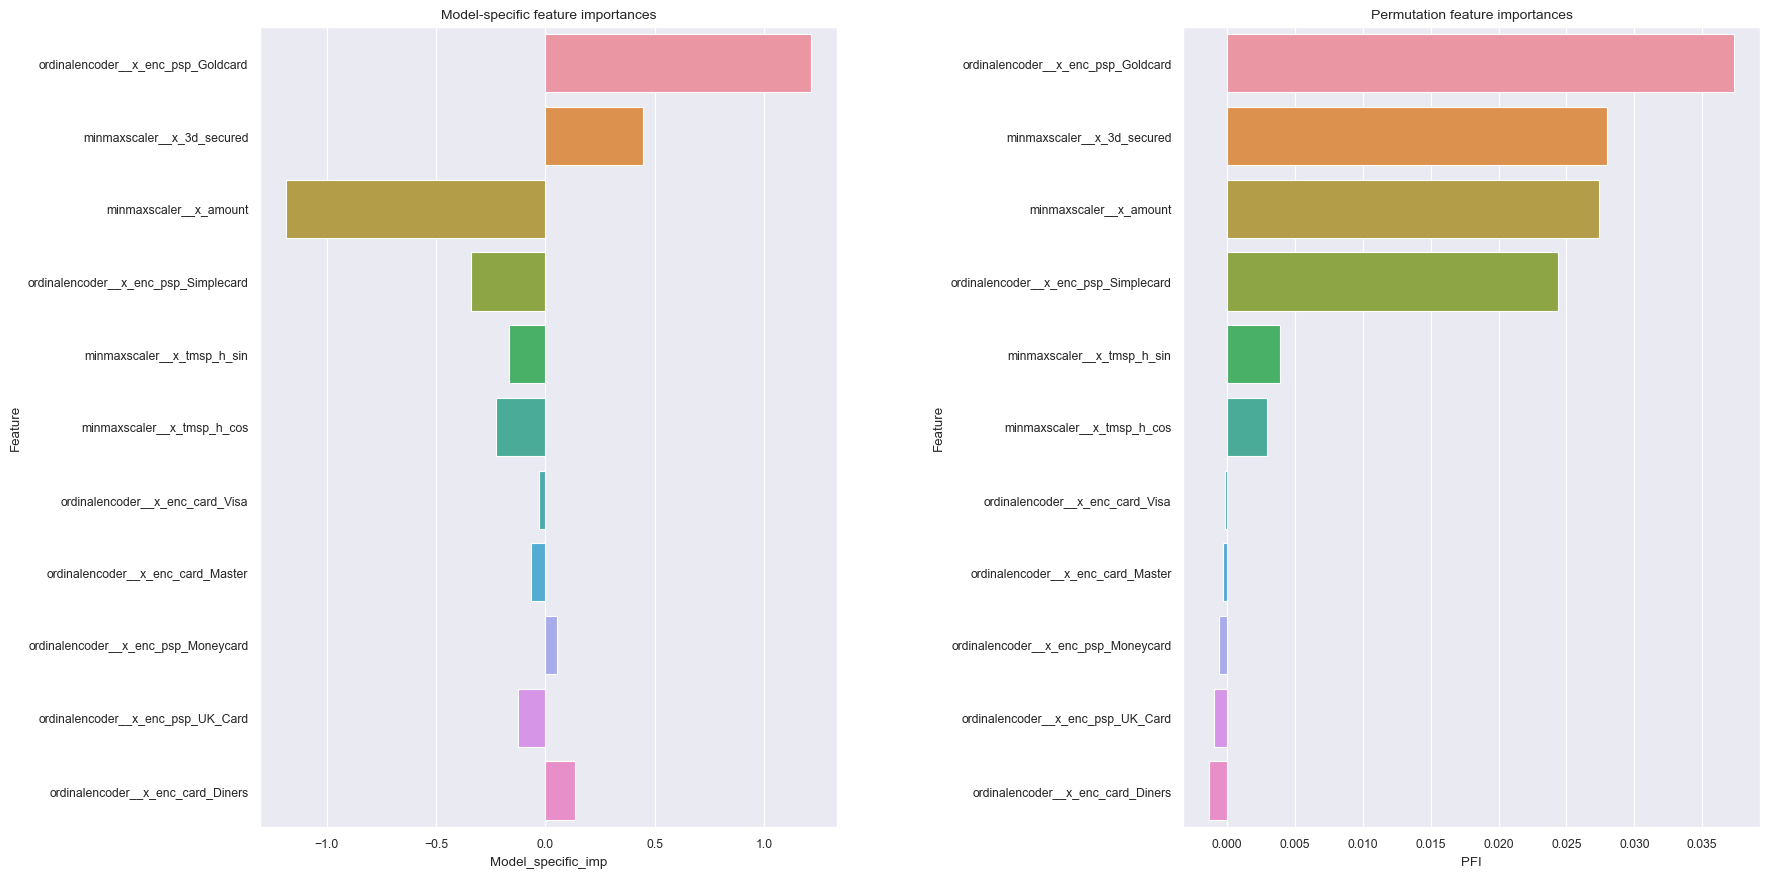

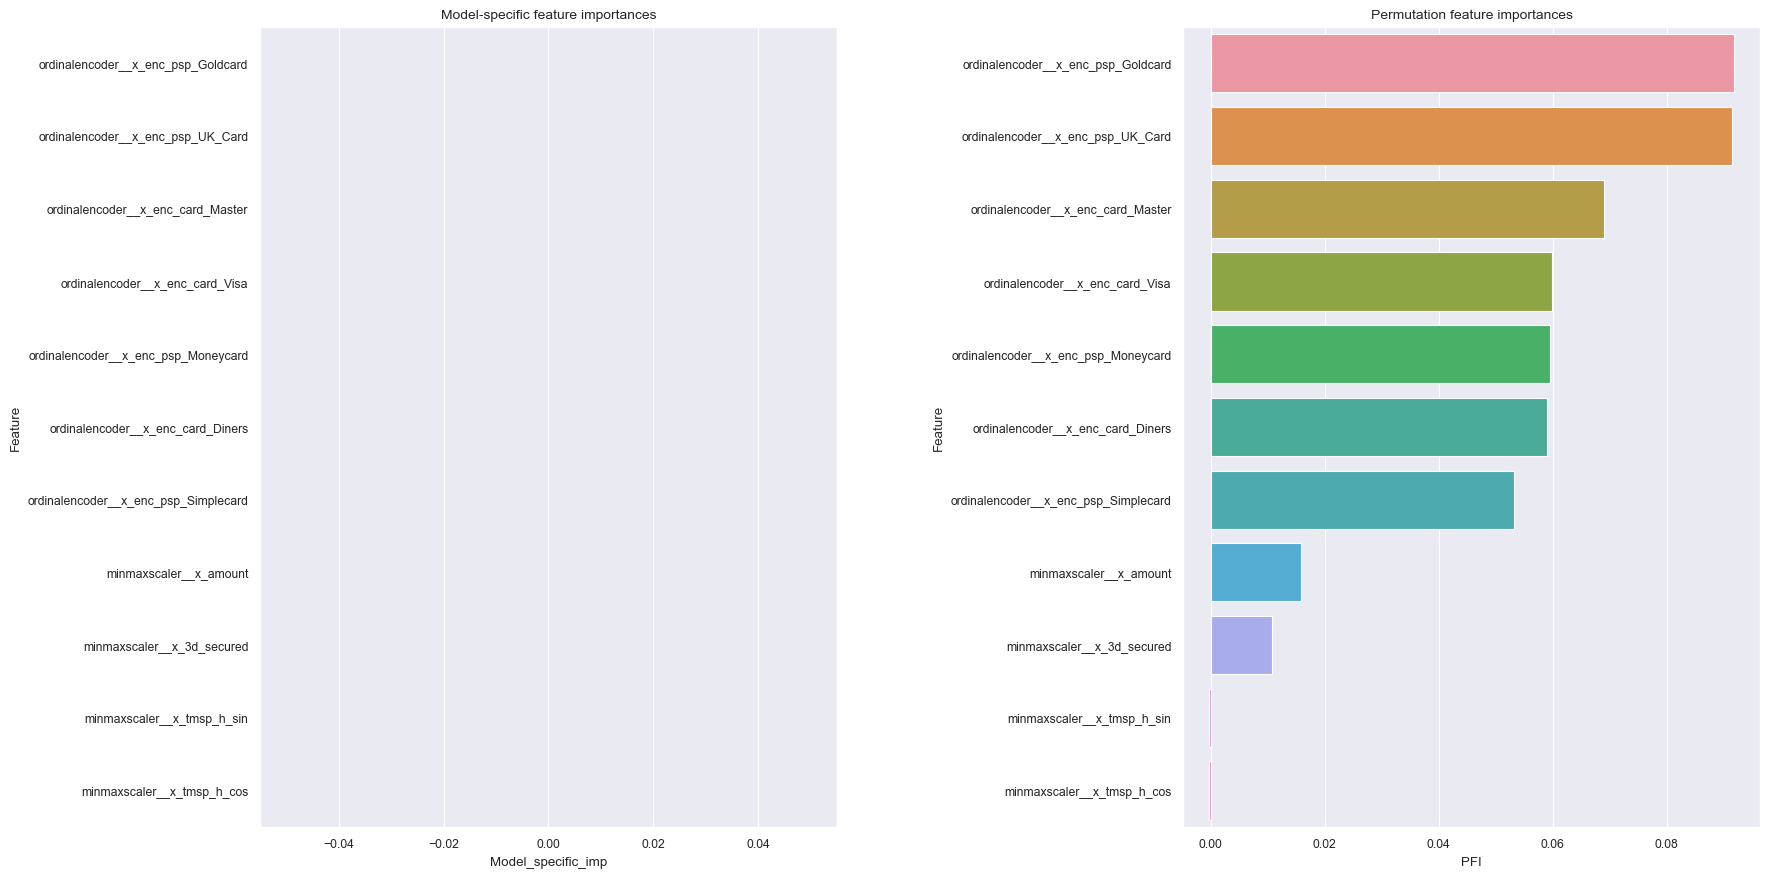

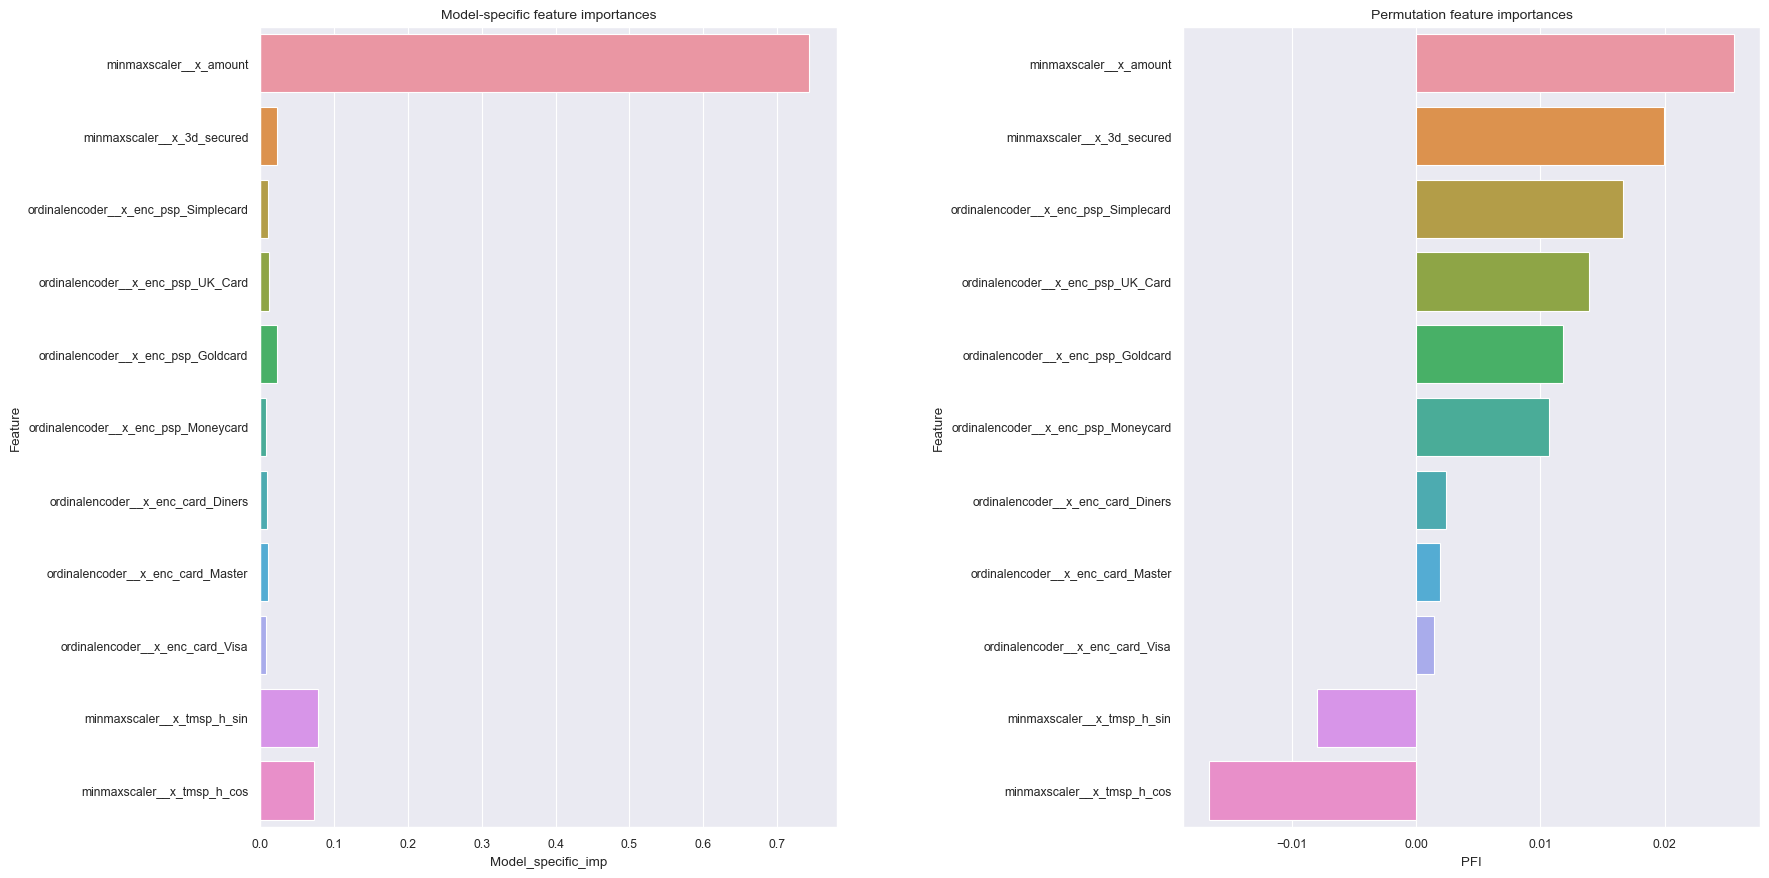

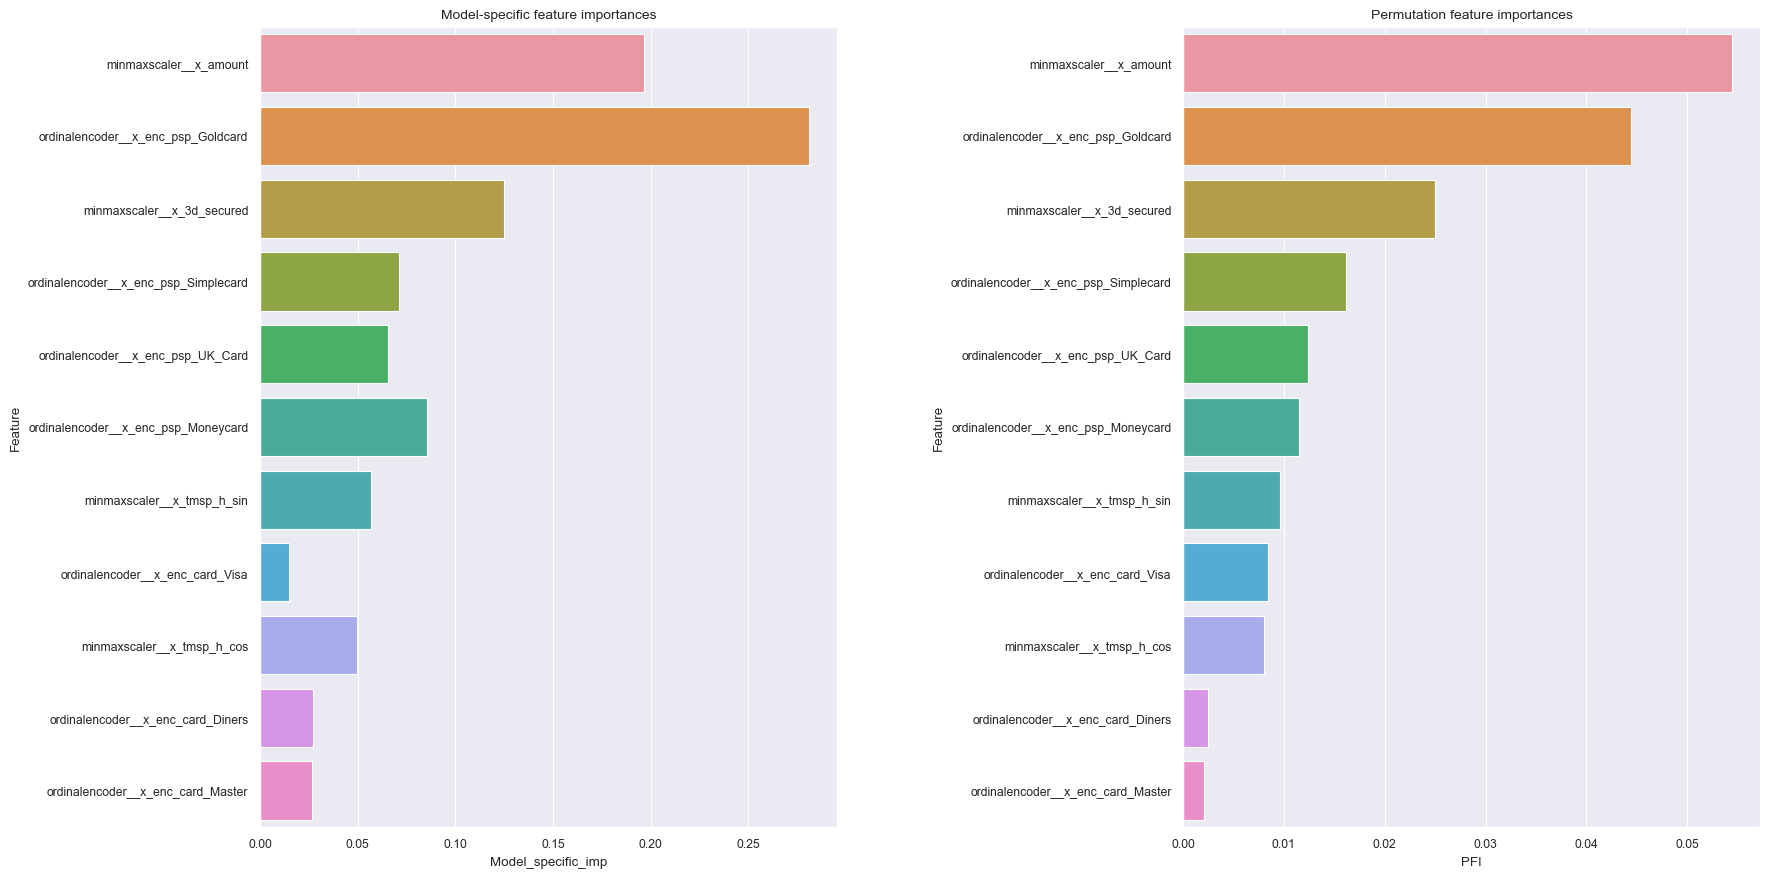

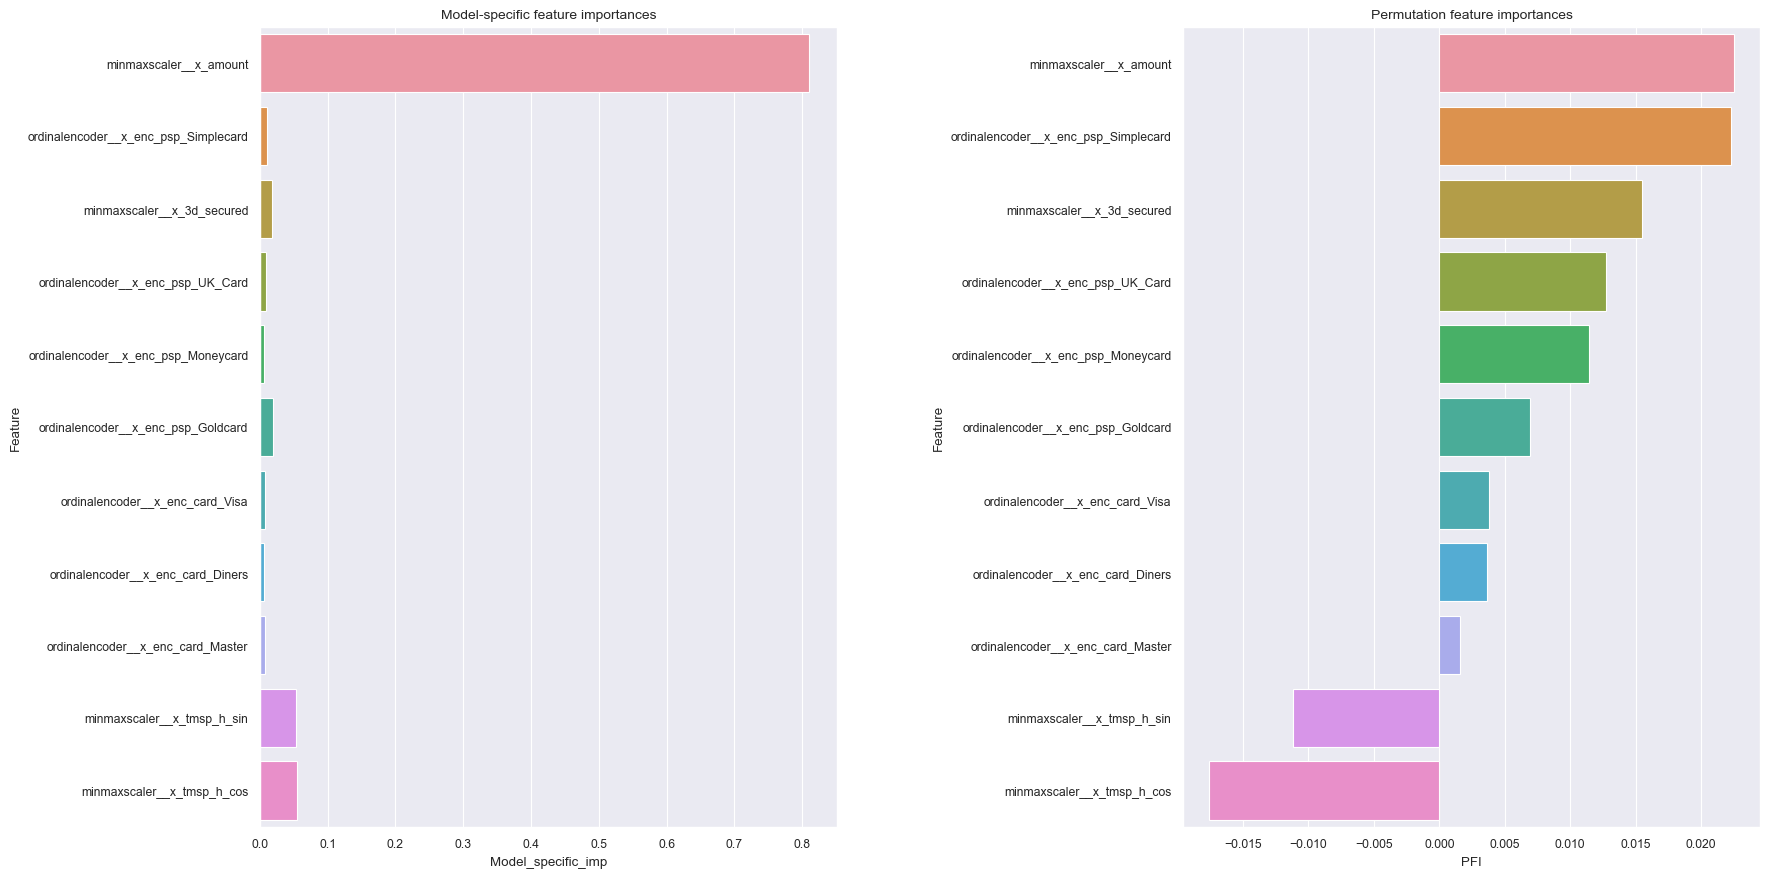

In [25]:
second_exp = "PSP_2b_w/_class_weights"
second_info = "2. Training of models w/ REDUCED features set &  WITHOUT hyperparameter tuning"
"""train_model(zip_iter=second_step_zip, 
            x_train_raw=x_train_raw_light, x_train_numerical=x_train_numerical_light, 
            x_test_raw=x_test_raw_light, x_test_numerical=x_test_numerical_light, 
            y_train=y_train, y_test=y_test,
            features_numerical=features_light, 
            exp_name=second_exp, info_text=second_info, 
            rs=rs)"""

# Modeling no. 3: Random search for hyperparameter tuning
Remove:
- Dummy
- Naive Bayes due to low optimization potential
- KNN due to high computing effort

In [26]:
# collect all models
# names
third_clf_names = ["Logistic Regression", 
                    "Decision Tree", 
                    "Linear SVM",  
                    "LDA", 
                    "QDA",
                    "Random Forest", 
                    "Gradient Boosting", 
                    "Extra Trees"]

# configure parameters per model
hp_baseline = {"strategy": ["most_frequent", "stratified"]}
hp_qda = {"reg_param": np.arange(0, 1.01, 0.1)}
hp_lda = {"shrinkage": [None, "auto"]}
hp_lr = {"penalty": ["l1", "l2", "elasticnet", None], 
         "C": np.arange(0.01, 10, 0.1), 
         "l1_ratio": np.arange(0.1, 1.01, 0.1)}
hp_knn = {"n_neighbors": np.arange(5, 75, 2), 
          "weights": ["uniform", "distance"], 
          "algorithm": ["ball_tree", "kd_tree", "brute"], 
          "p": np.arange(1, 3.0, 0.1)}
hp_dt = {"criterion": ["gini", "entropy", "log_loss"], 
         "splitter": ["best", "random"], 
         "max_depth": np.arange(2, 52, 2), 
         "min_samples_split": np.arange(2, 52, 2), 
         "min_samples_leaf": np.arange(1, 32, 2)}
hp_lin_svm = {"penalty": ["l1", "l2"], 
              "C": np.arange(0, 15, 0.5)}
hp_rf = {"n_estimators": np.arange(10, 300, 20), 
         "criterion": ["gini", "entropy", "log_loss"], 
         "max_depth": np.arange(2, 60, 2), 
         "min_samples_split": np.arange(2, 50, 2), 
         "min_samples_leaf": np.arange(1, 30, 2), 
         "max_features": [None, "sqrt", "log2"]}
hp_grad_boost = {"loss": ["log_loss", "exponential"], 
                 "learning_rate":np.arange(0.1, 1.5, 0.1), 
                 "subsample": np.arange(0.3, 0.99, 0.1), 
                 "criterion": ["friedman_mse", "squared_error"], 
                 "min_samples_split": np.arange(2, 50, 2), 
                 "min_samples_leaf": np.arange(1, 30, 2), 
                 "max_depth": np.arange(2, 20, 1), 
                 "max_features": [None, "sqrt", "log2"]}
hp_extra = {"criterion": ["gini", "entropy", "log_loss"], 
            "max_depth": np.arange(2, 60, 2), 
            "min_samples_split": np.arange(2, 52, 2), 
            "min_samples_leaf": np.arange(1, 32, 2), 
            "max_features": [None, "sqrt", "log2"], 
            "min_weight_fraction_leaf": np.arange(0, 0.5, 0.1), 
            "bootstrap": [True, False]}

# parameters collected
third_params = [hp_lr, hp_dt, hp_lin_svm, hp_lda, hp_qda, hp_rf, hp_grad_boost, hp_extra]

# sklearn models
third_clf = [LogisticRegression(solver="saga", class_weight="balanced", **params_rs),  
              DecisionTreeClassifier(class_weight="balanced", **params_rs),
              LinearSVC(dual="auto", class_weight="balanced", **params_rs), 
              LinearDiscriminantAnalysis(solver="lsqr"), 
              QuadraticDiscriminantAnalysis(),
              RandomForestClassifier(class_weight="balanced_subsample", **params_rs), 
              GradientBoostingClassifier(**params_rs), 
              ExtraTreesClassifier(class_weight="balanced_subsample", **params_rs)]

# feature mode for model
third_feat_mode = ["numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric", 
                    "numeric"]

third_zip = zip(third_clf_names, third_clf, third_params, third_feat_mode)
print(f"length of clf_names {len(third_clf_names)} & clf {len(third_clf)} & parameters {len(third_params)} & feat_mode {len(third_feat_mode)}")

length of clf_names 8 & clf 8 & parameters 8 & feat_mode 8


Training and logging of model Logistic Regression as classifier LogisticRegression(class_weight='balanced', random_state=23, solver='saga') with feature mode numeric
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.3s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.2s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.3s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.1s
[CV] END ...C=1.4100000000000001, l1_ratio=0.9, penalty=None; total time=   0.1s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.2s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.3s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.4s
[CV] END ...........C=1.81, l1_ratio=0.6, penalty=elasticnet; total time=   0.3s
[CV] END ...........C=1.81, l1_ratio=0.6, p

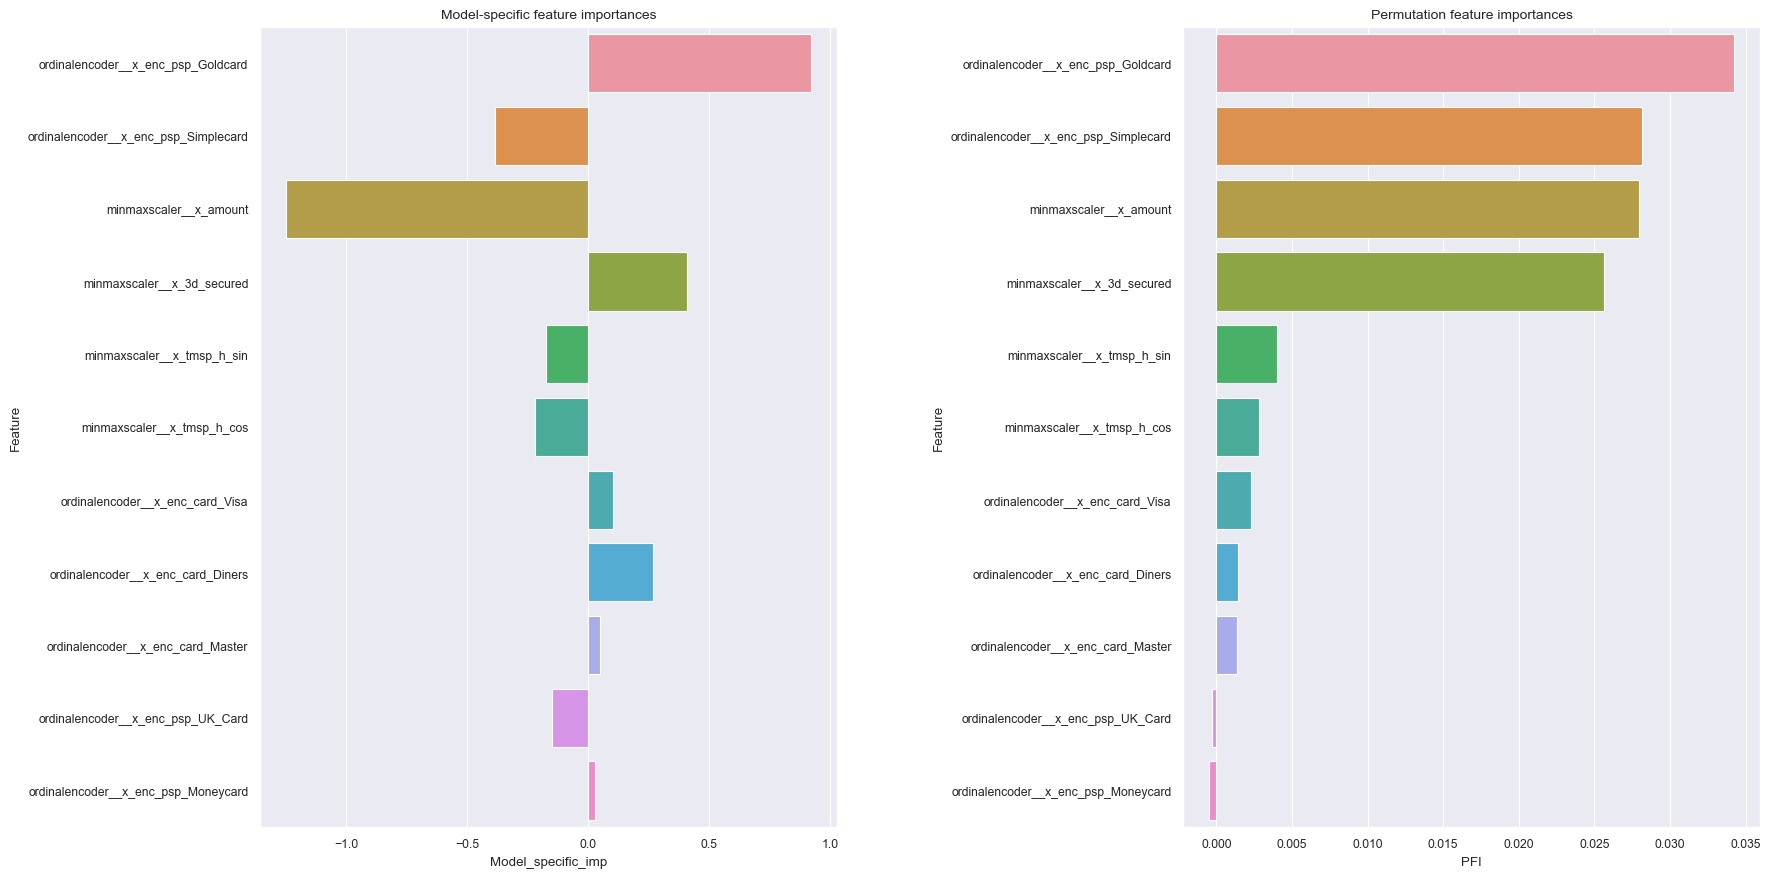

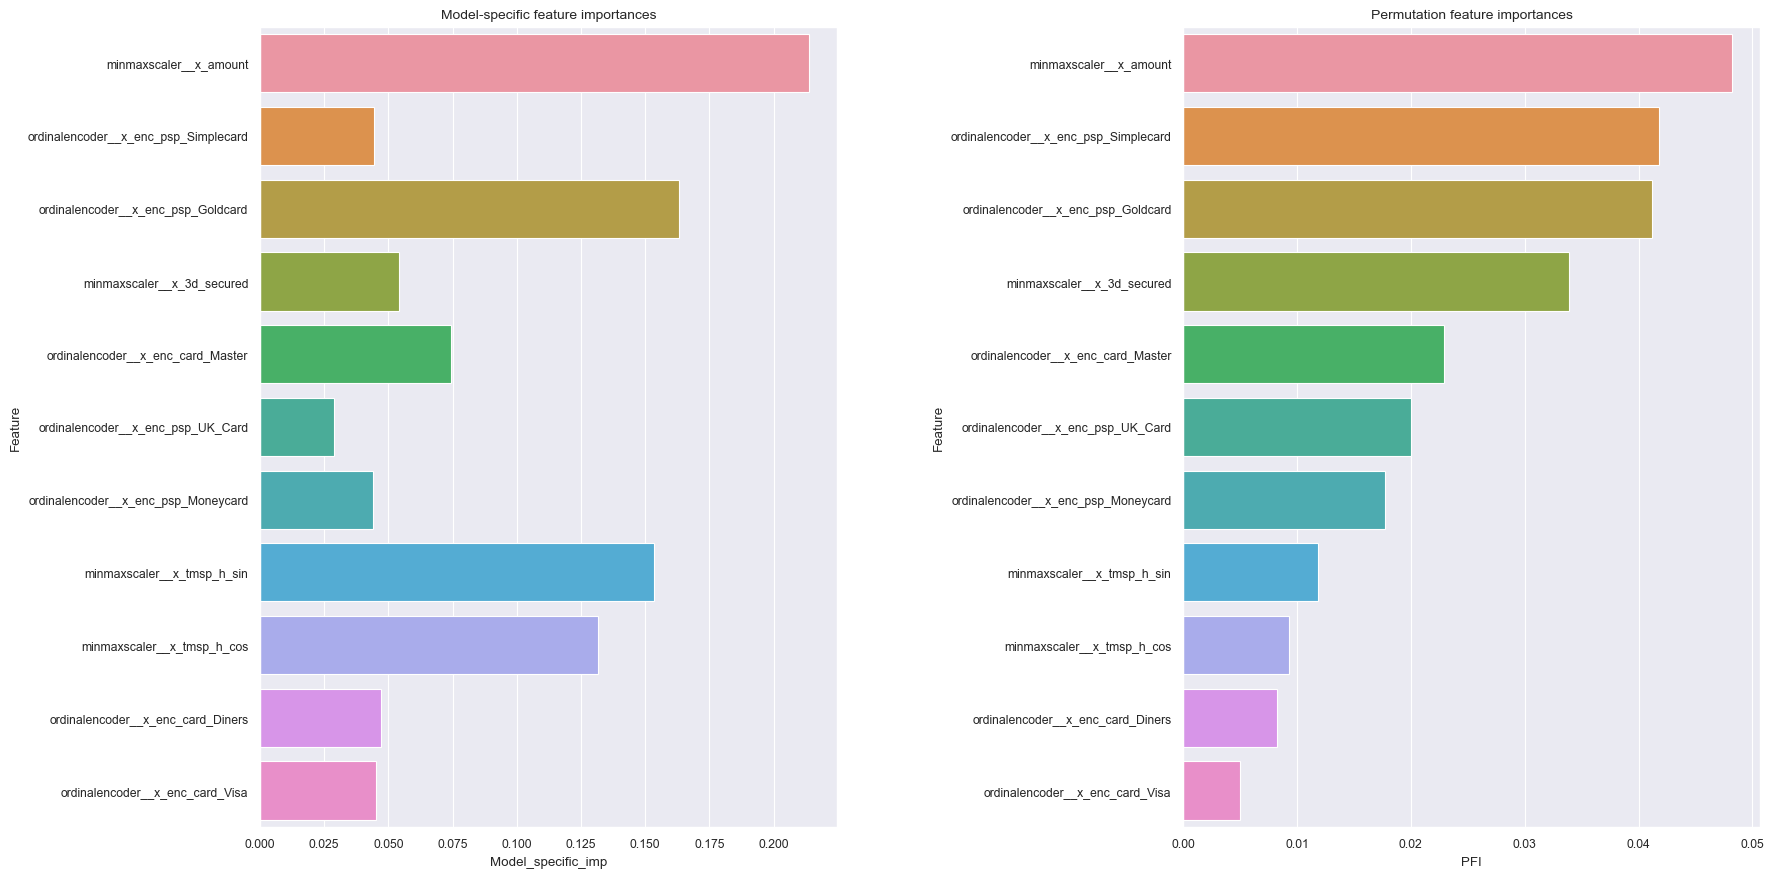

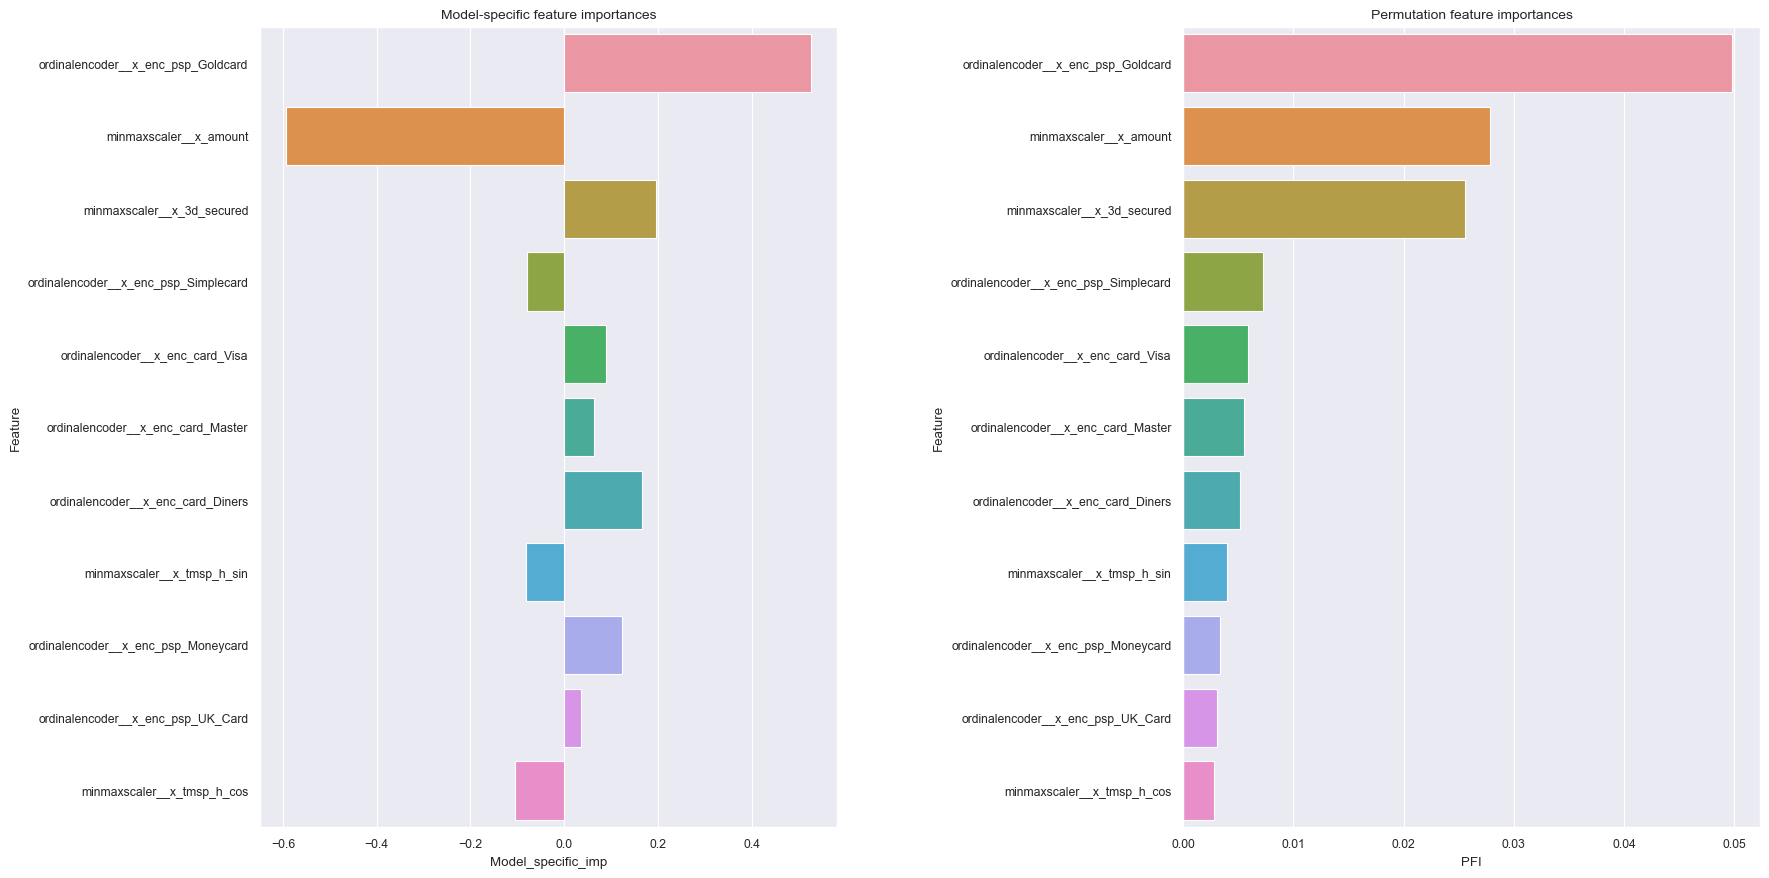

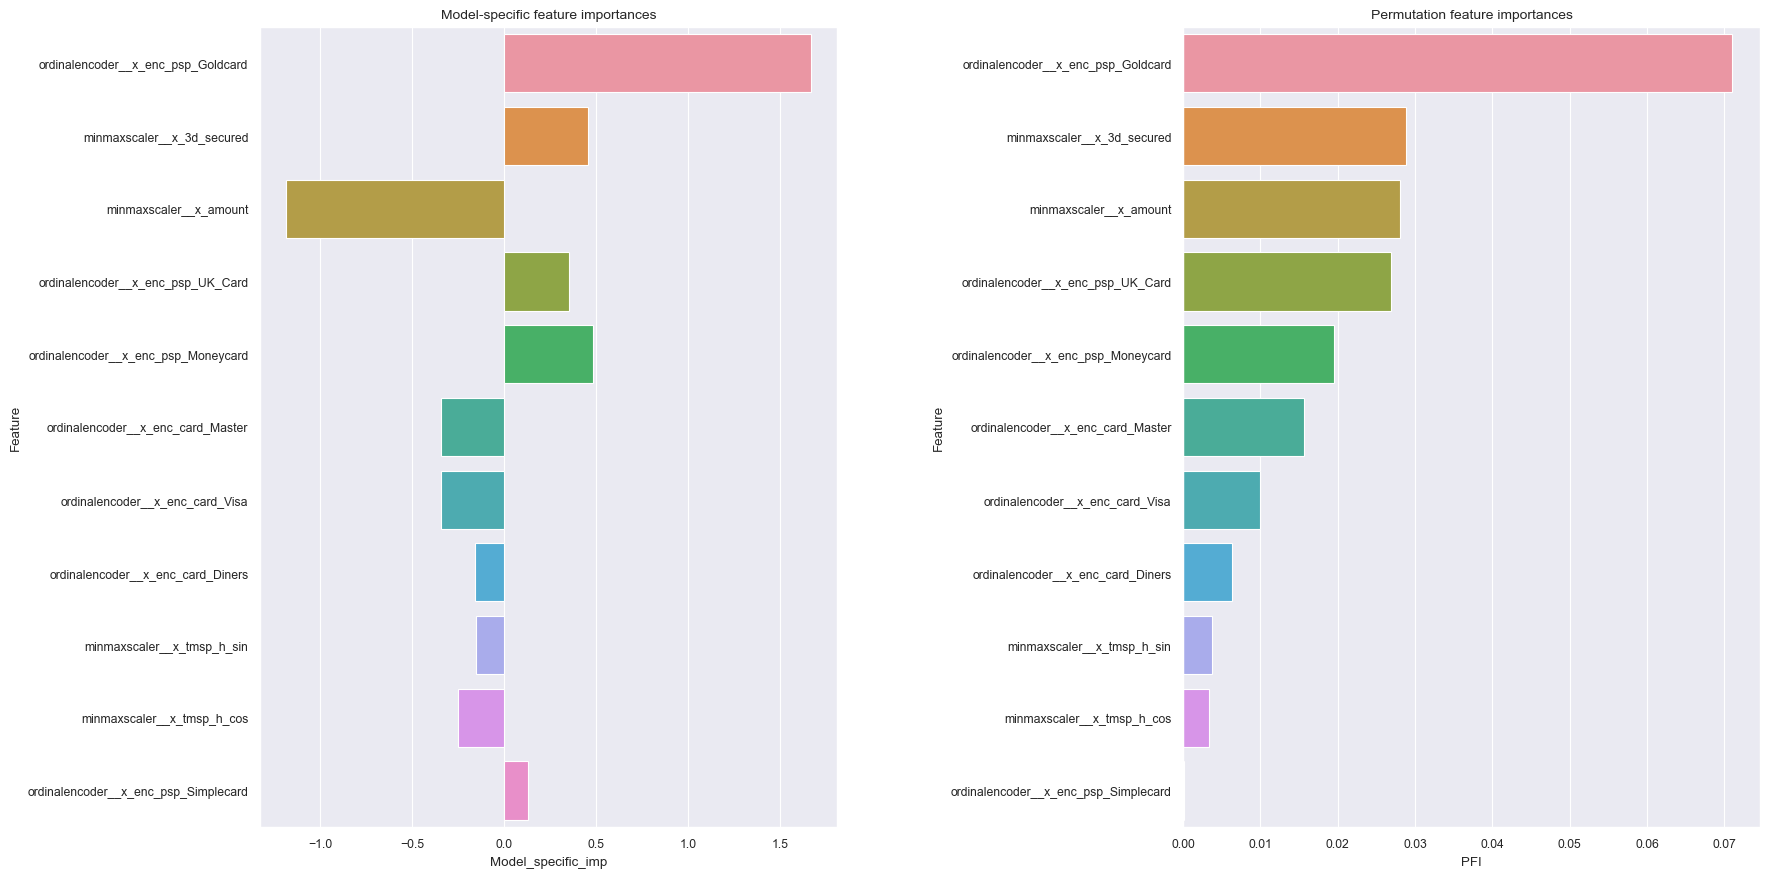

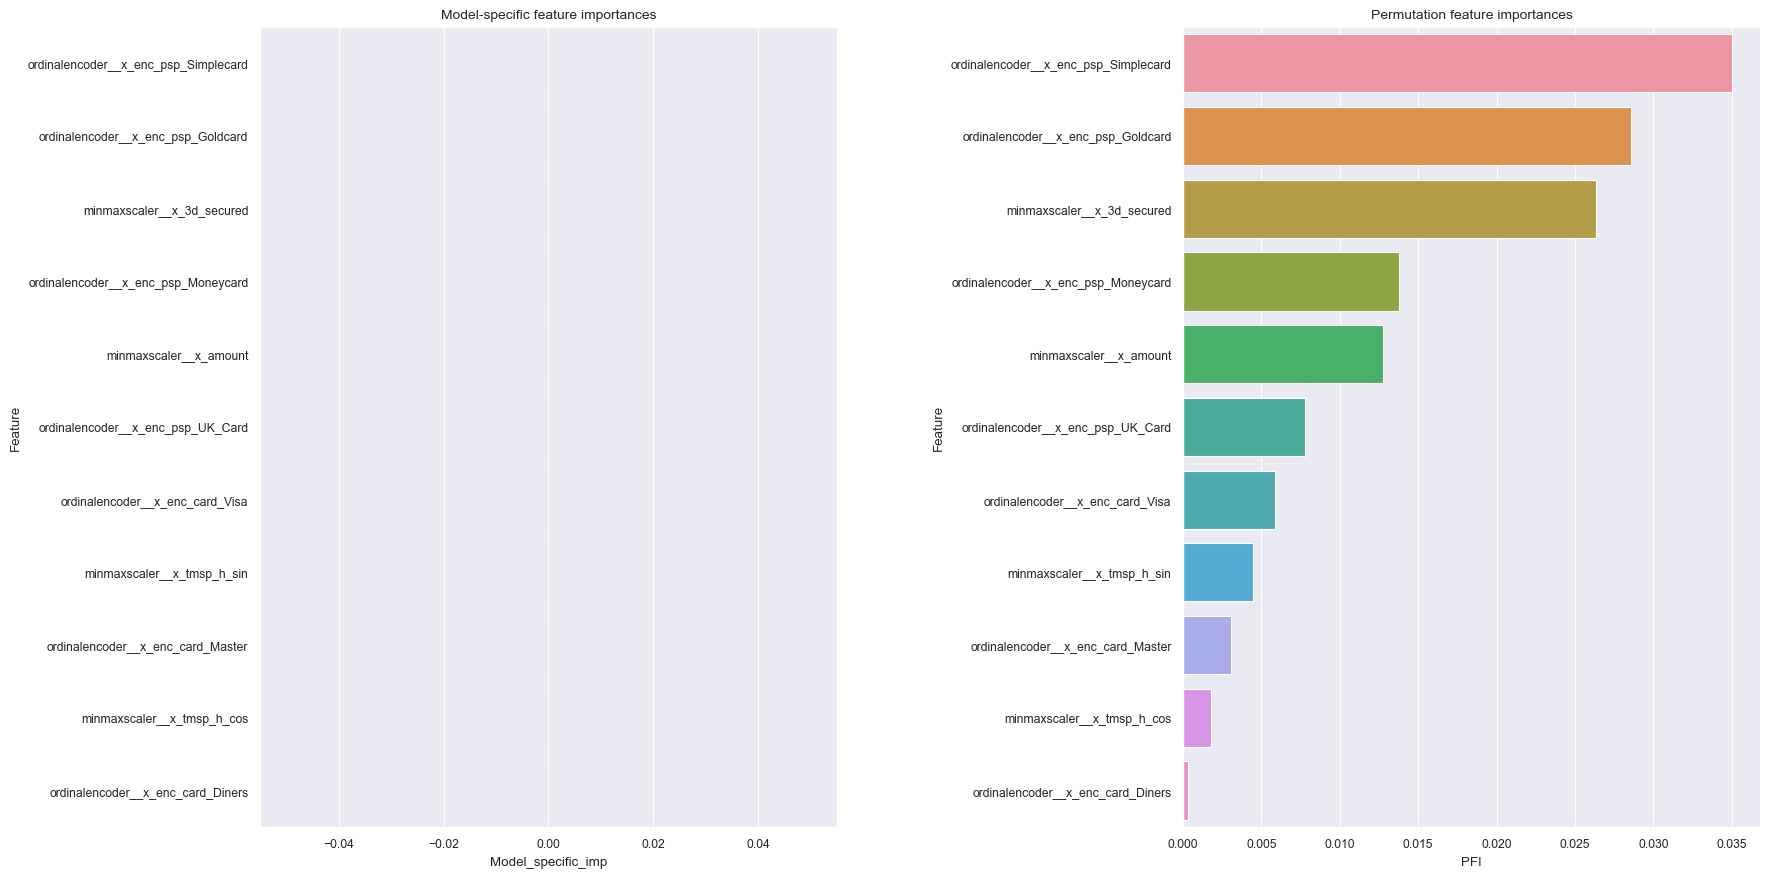

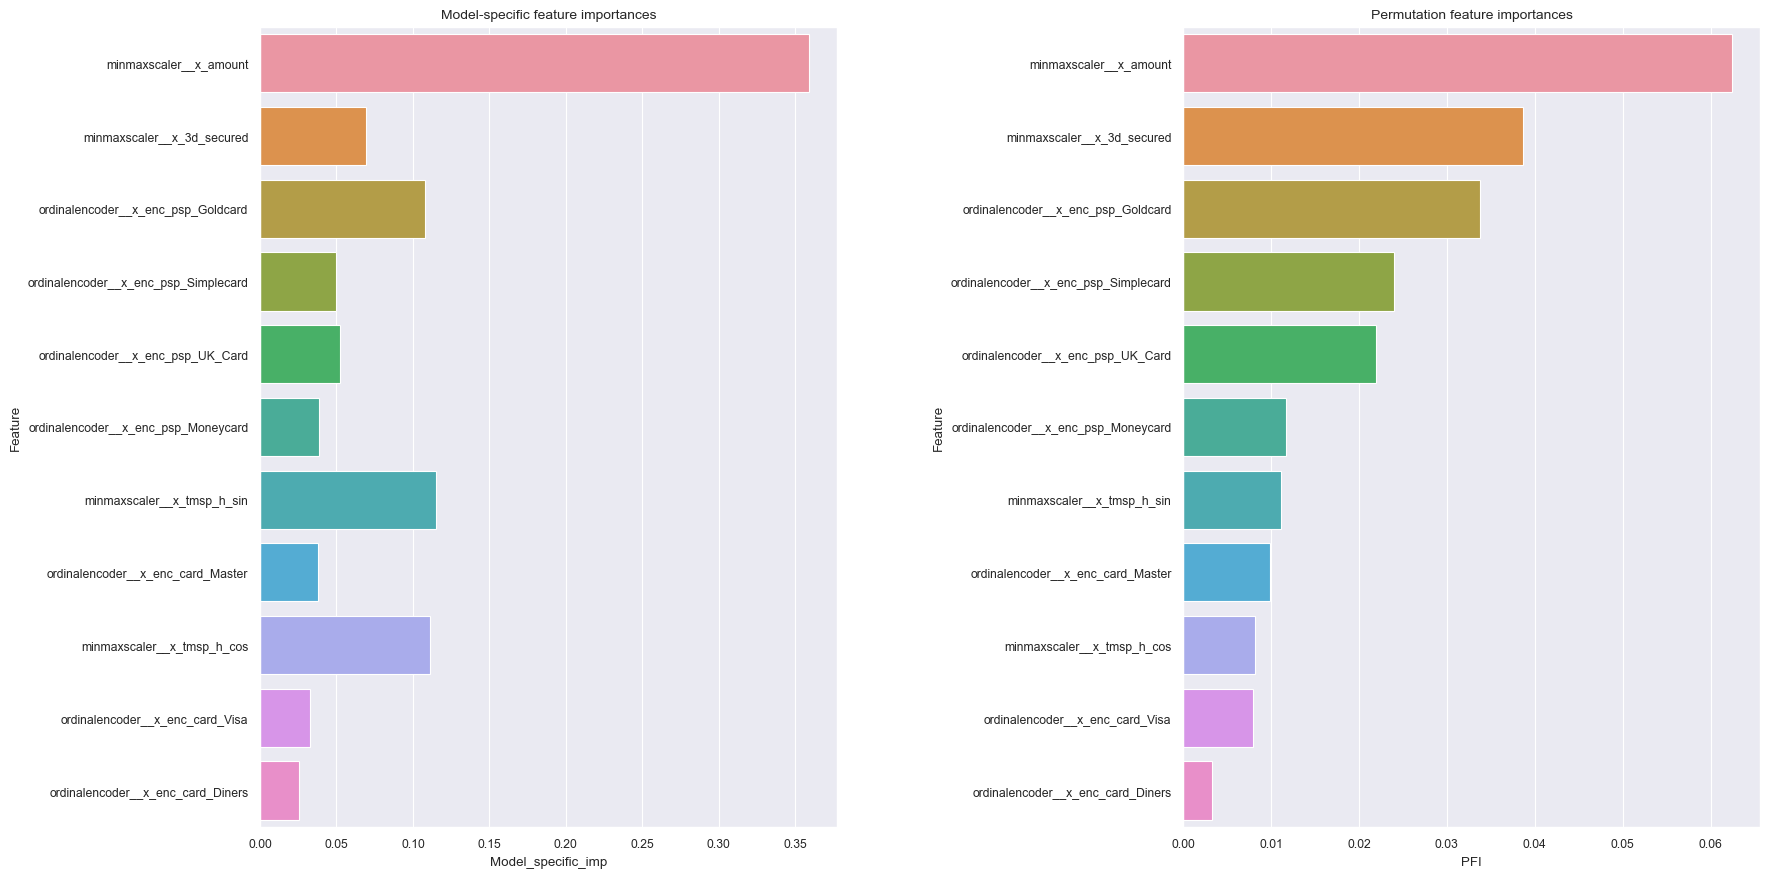

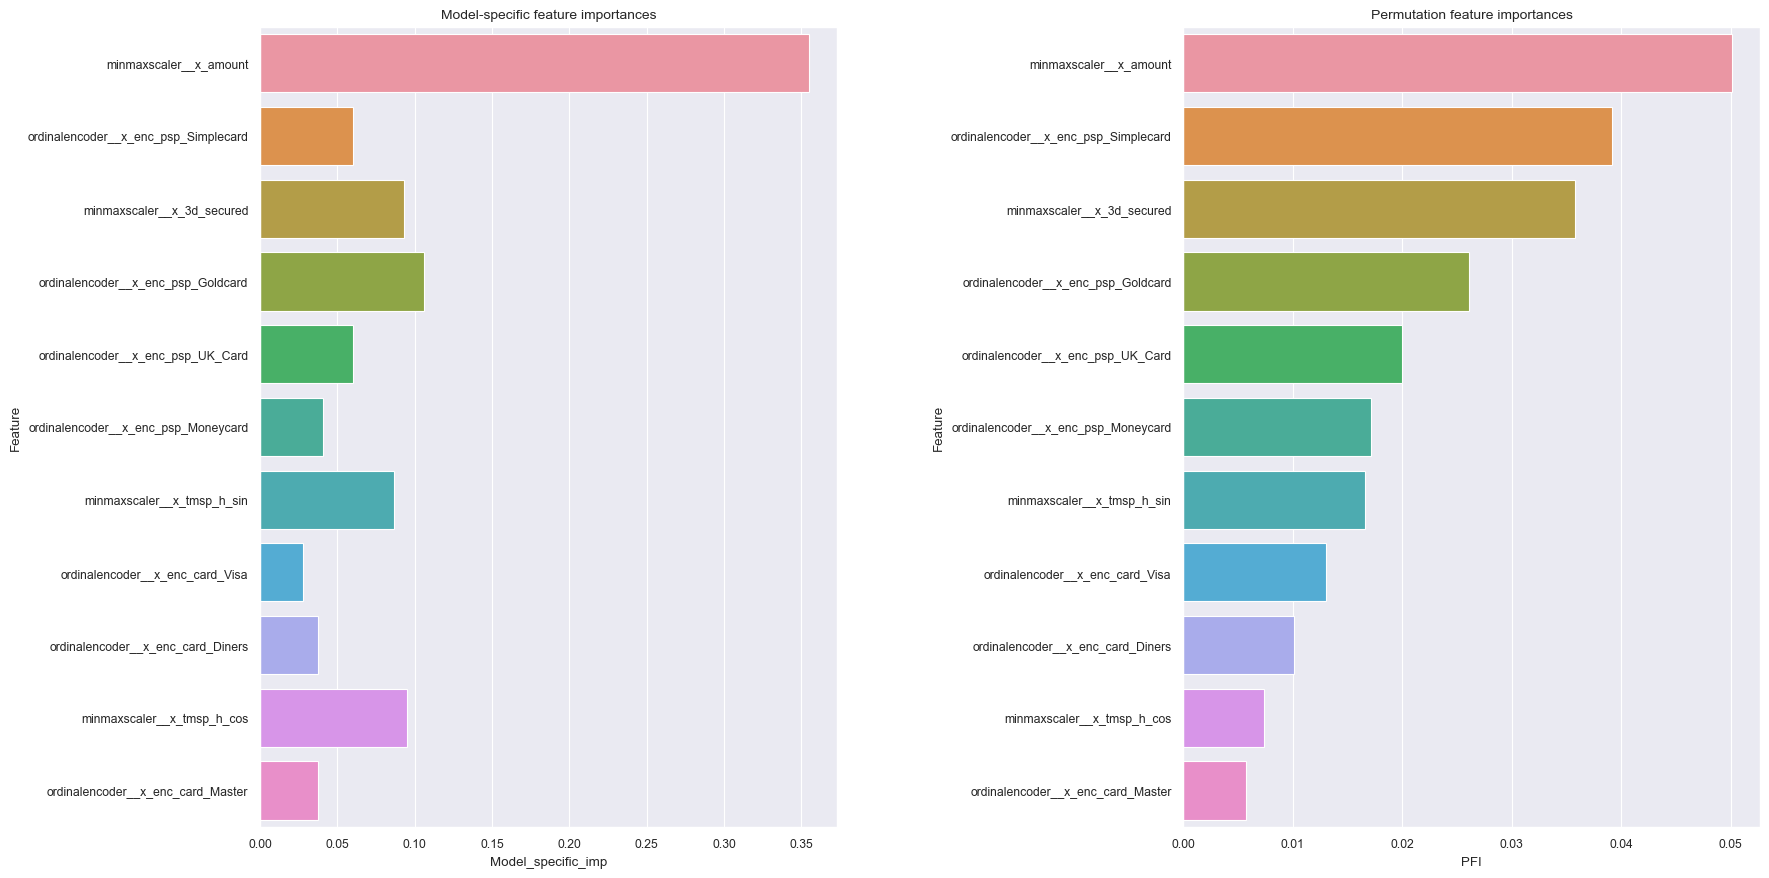

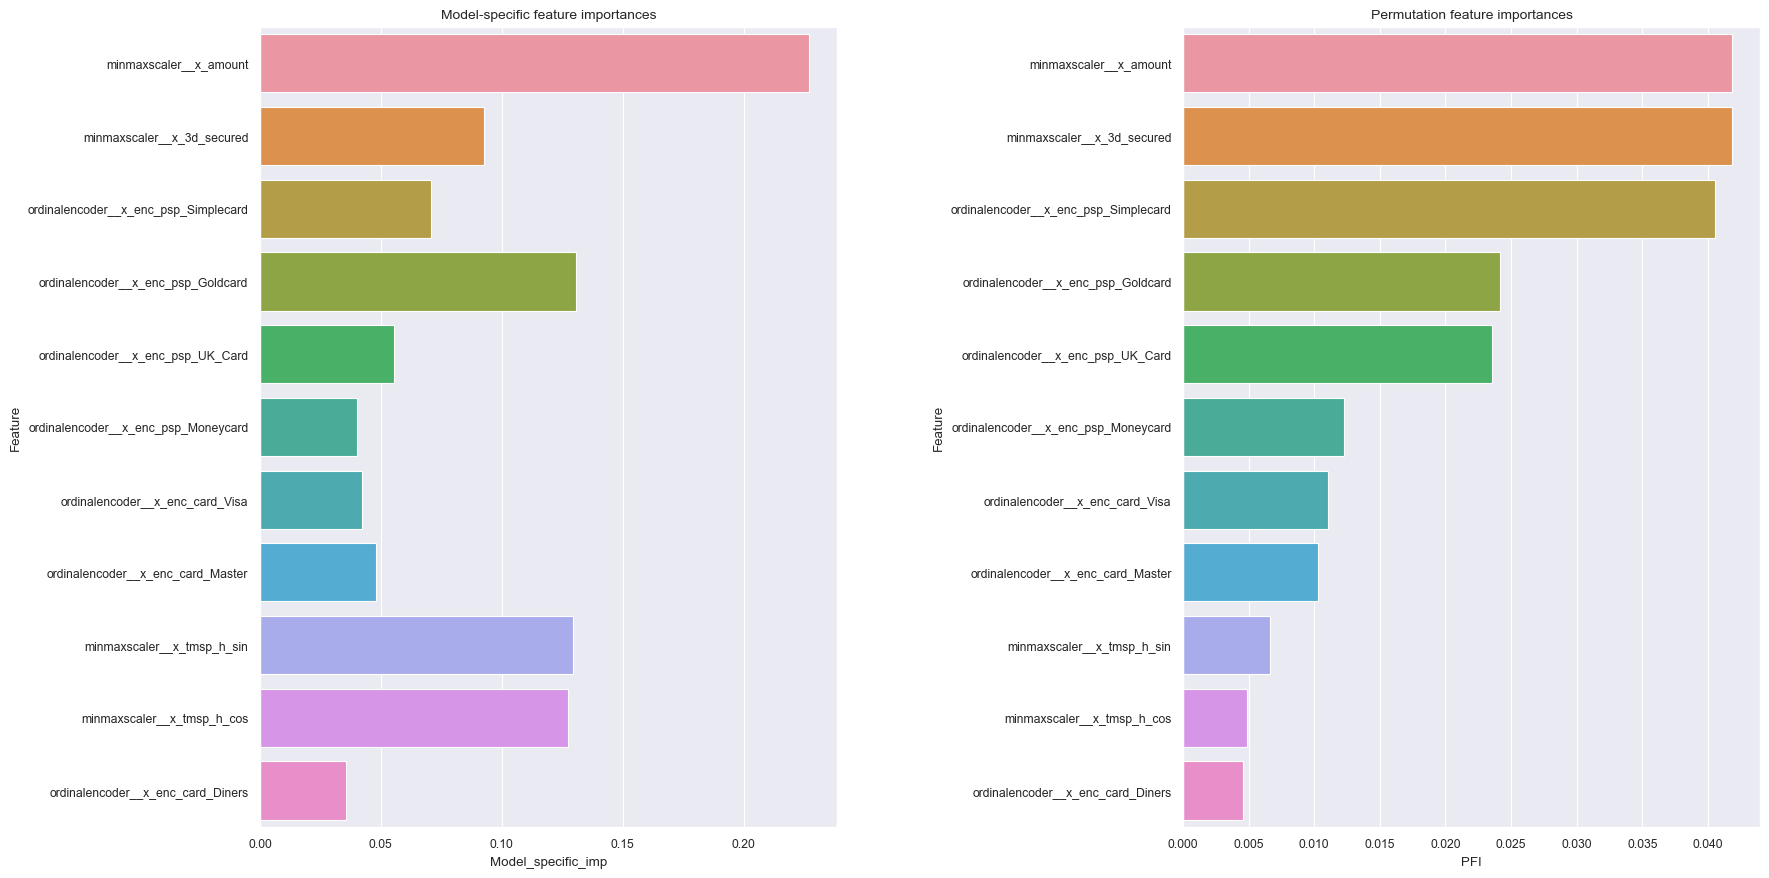

In [27]:
third_exp = "PSP_3b_HP-tune_w/_class_weights"
third_info = "3. Training of models WITH hyperparameter tuning & w/ REDUCED features set "
"""hp_tune_model(search_mode="random", 
              zip_iter=third_zip, 
              x_train_raw=x_train_raw_light, x_train_numerical=x_train_numerical_light, 
              x_test_raw=x_test_raw_light, x_test_numerical=x_test_numerical_light, 
              y_train=y_train, y_test=y_test, 
              features_numerical=features_light, 
              exp_name=third_exp, info_text=third_info, 
              rs=rs)"""

# Modeling no. 4: Fine-tuning of Top2-models via GridSearch & pick best

In [28]:
# collect all models
# names
fourth_clf_names = ["Random Forest", "Extra Trees"]

# configure parameters per model
hp_fine_rf = {"max_depth": np.arange(25, 45, 1)}
hp_fine_extra = {"max_depth": np.arange(5, 20, 1)}

# parameters collected
fourth_params = [hp_fine_rf, hp_fine_extra]

# sklearn models
fourth_clf = [RandomForestClassifier(class_weight="balanced_subsample", 
                                     bootstrap=True, n_estimators=130,
                                     min_samples_split=2, min_samples_leaf=29,
                                     criterion="log_loss", max_features="sqrt", 
                                     random_state=rs), 
              ExtraTreesClassifier(class_weight="balanced_subsample", criterion="gini", 
                                   min_samples_split=32, min_samples_leaf=7, 
                                   max_features="sqrt", min_weight_fraction_leaf=0, 
                                   bootstrap=True, random_state=rs)]

# feature mode for model
fourth_feat_mode = ["numeric", "numeric"]

fourth_zip = zip(fourth_clf_names, fourth_clf, fourth_params, fourth_feat_mode)
print(f"length of clf_names {len(fourth_clf_names)} & clf {len(fourth_clf)} & parameters {len(fourth_params)} & feat_mode {len(fourth_feat_mode)}")

length of clf_names 2 & clf 2 & parameters 2 & feat_mode 2


Training and logging of model Random Forest as classifier RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       min_samples_leaf=29, n_estimators=130, random_state=23) with feature mode numeric
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .......................................max_depth=25; total time=   3.3s
[CV] END .......................................max_depth=25; total time=   3.3s
[CV] END .......................................max_depth=25; total time=   2.8s
[CV] END .......................................max_depth=25; total time=   3.2s
[CV] END .......................................max_depth=25; total time=   3.5s
[CV] END .......................................max_depth=26; total time=   3.4s
[CV] END .......................................max_depth=26; total time=   2.9s
[CV] END .......................................max_depth=26; total time=   3.2s
[CV] END ......................................

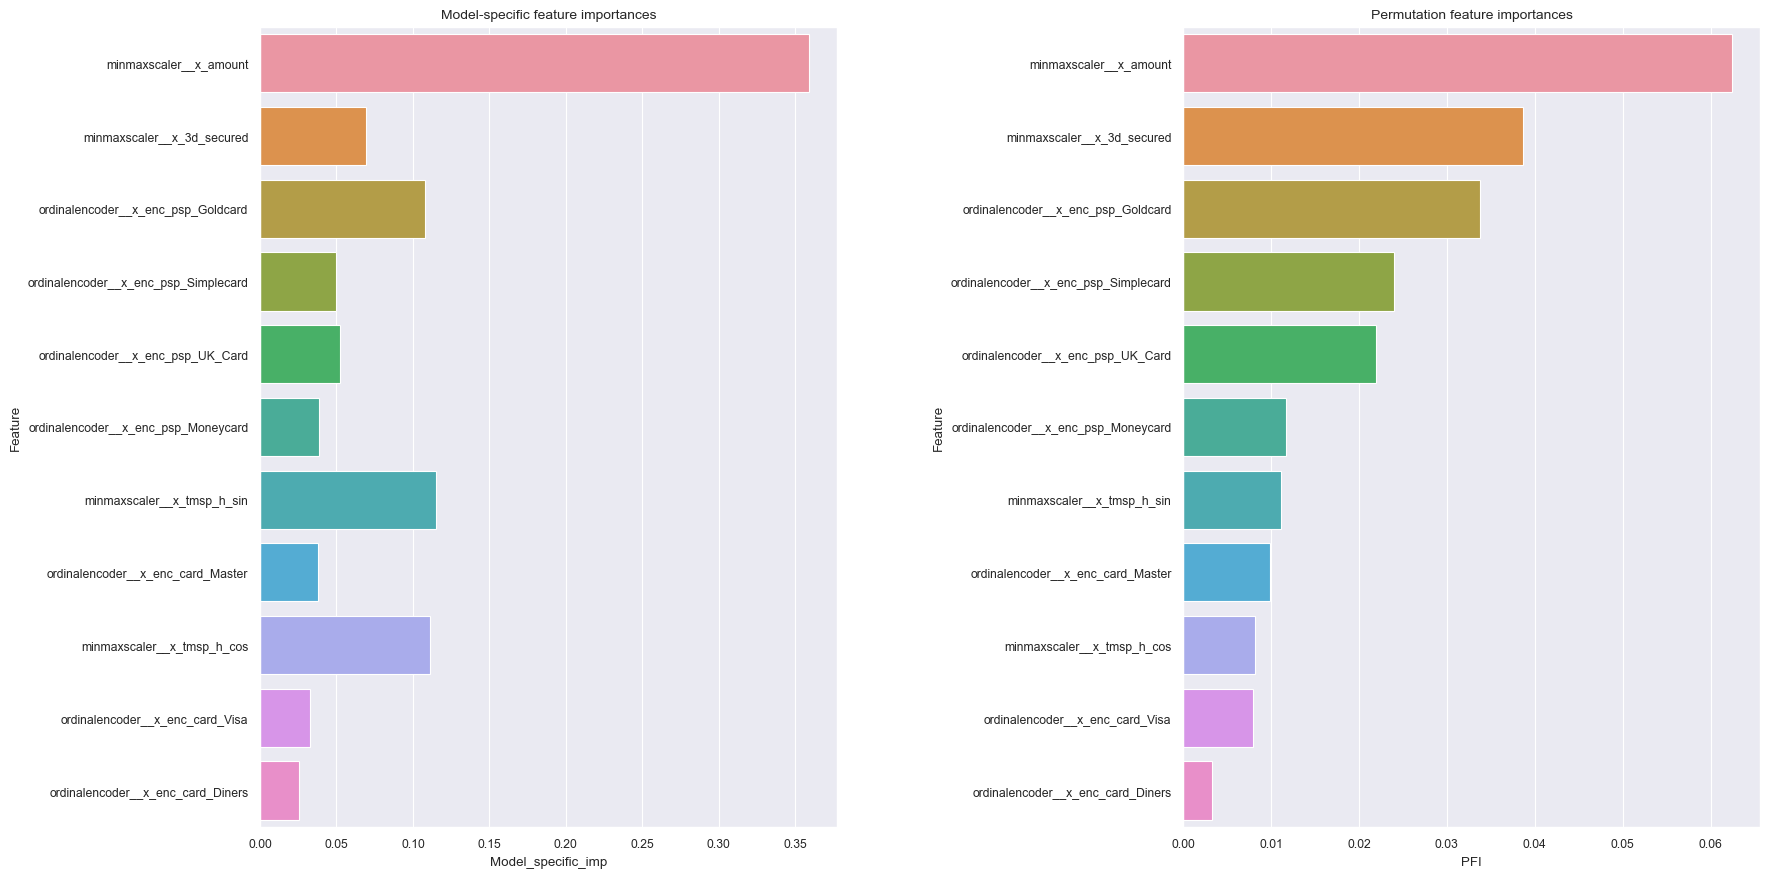

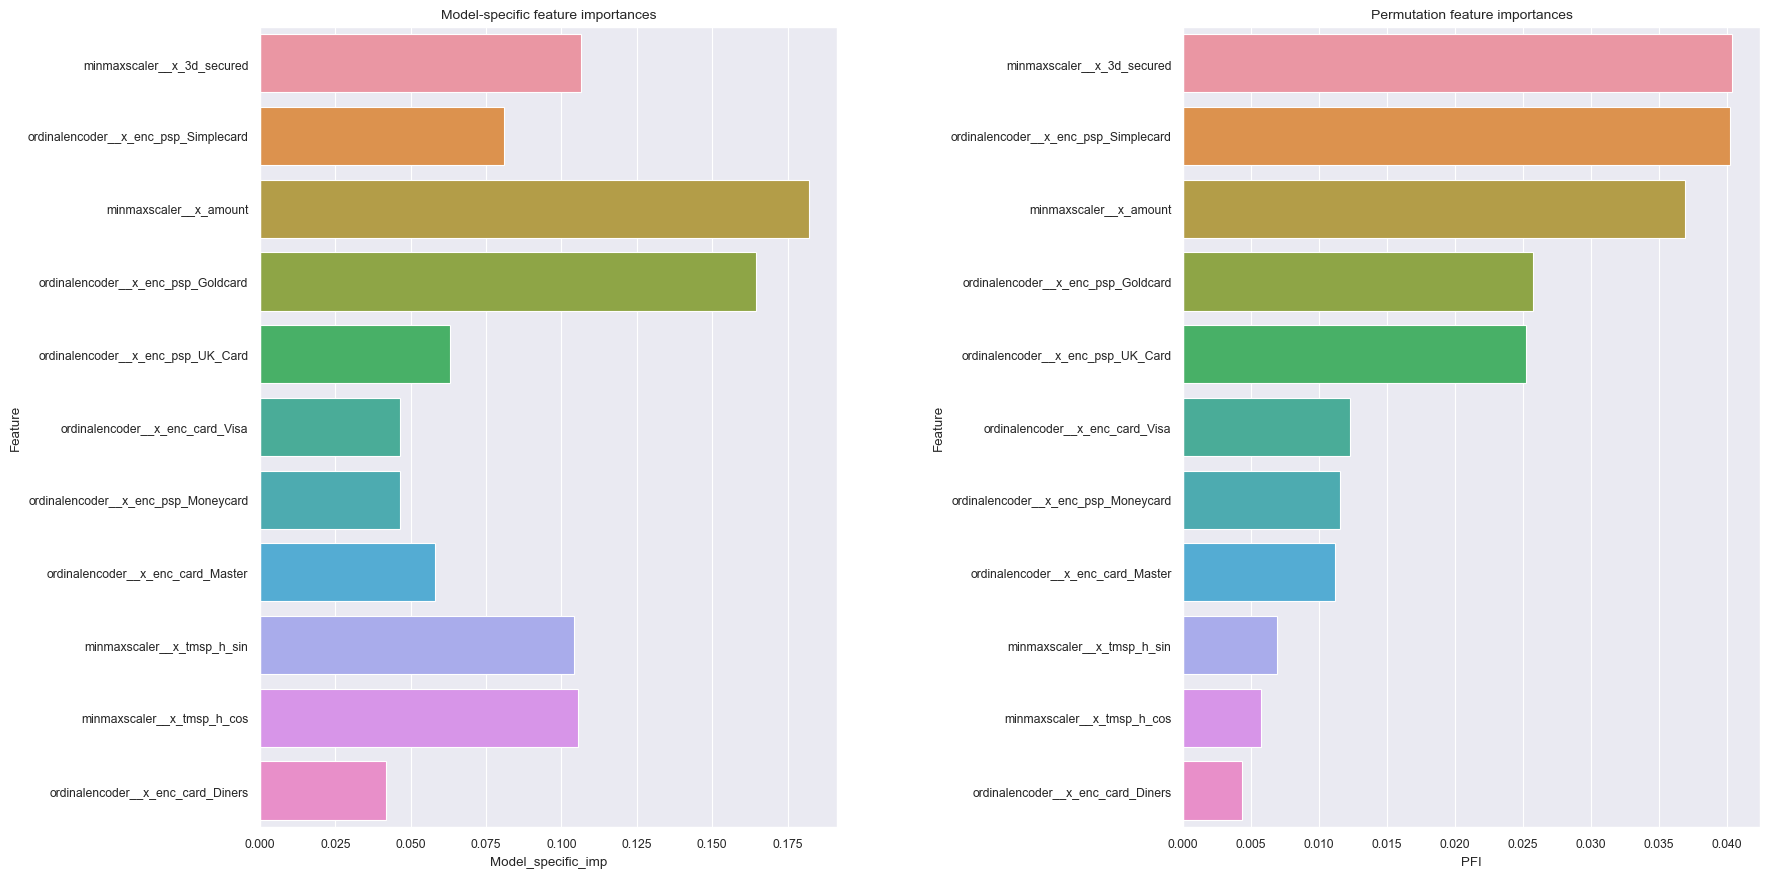

In [29]:
fourth_exp = "PSP_4b_finetune_w/_class_weights"
fourth_info = "4. Training of models WITH hyperparameter tuning & w/ REDUCED features set "
"""hp_tune_model(search_mode="grid", 
              zip_iter=fourth_zip, 
              x_train_raw=x_train_raw_light, x_train_numerical=x_train_numerical_light, 
              x_test_raw=x_test_raw_light, x_test_numerical=x_test_numerical_light, 
              y_train=y_train, y_test=y_test, 
              features_numerical=features_light, 
              exp_name=fourth_exp, info_text=fourth_info, 
              rs=rs)"""

> Random Forest with best performance

In [30]:
logged_model = "runs:/56c67ee16bec42f0a1bf72135dad4df9/model_saved"

# Load model as a sklearn-model.
best_model = mlflow.sklearn.load_model(logged_model)

# Evaluate selected model

## ROC & AUC of selected model

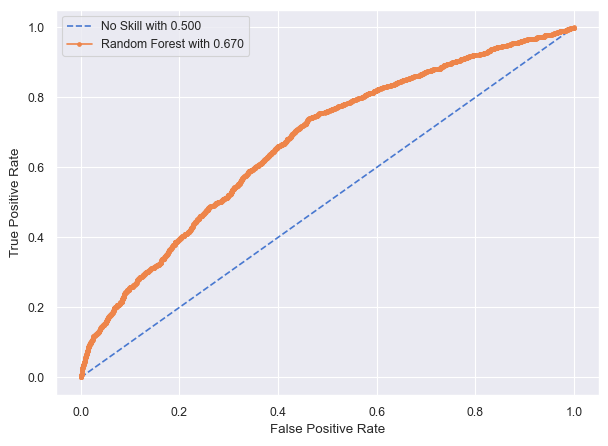

In [31]:
y_pred = best_model.predict(x_test_numerical_light)
y_pred_probs = best_model.predict_proba(x_test_numerical_light)[:, 1]

# calculate ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
# calculate AUC
auc = roc_auc_score(y_test, y_pred_probs)

# No SKILL-baseline: generate a no skill prediction 
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

plt.figure(figsize=(plot_width-5, plot_height-3))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=(f"No Skill with {ns_auc:.3f}"))
plt.plot(fpr, tpr, marker='.', label=(f"Random Forest with {auc:.3f}"))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig("../reports/figures/7-1_roc_curve.png")
plt.show()
plt.close()

## AUC per PSP
Da wir letztendlich die Entscheidung über den PSP nicht dem Modell mittels Schwellwert überlassen, sondern eher am Vergleich der Wahrscheinlichkeiten interessiert sind, sollte die Performance in definierten Bereichen auch nur über den AUC überprüft werden.

In [32]:
# list with PSPs and respective costs
df_psp_cost = (pd.read_excel("../data/04_processed/df_cost_in.xlsx", sheet_name="df_cost_in")
          .drop(columns=["Unnamed: 0"]))
#df_psp_cost

In [33]:
# all PSPs
list_psp = df_psp_cost["PSP_name"].to_list()
dict_psp_auc = dict()
dict_psp_count = dict()

for p in list_psp:
    # search column for PSP in features
    col_idx = [list(features_light).index(i) for i in features_light if (i.find(p)!=-1)][0]
    filter_psp = (x_test_numerical_light[:, col_idx] == 1) # filter for 1 in col
    
    count = y_pred_probs[filter_psp].shape[0] # count no. of data points
    dict_psp_count[p] = count
    
    # calculate AUC
    auc = roc_auc_score(y_test[filter_psp], y_pred_probs[filter_psp])
    dict_psp_auc[p] = auc

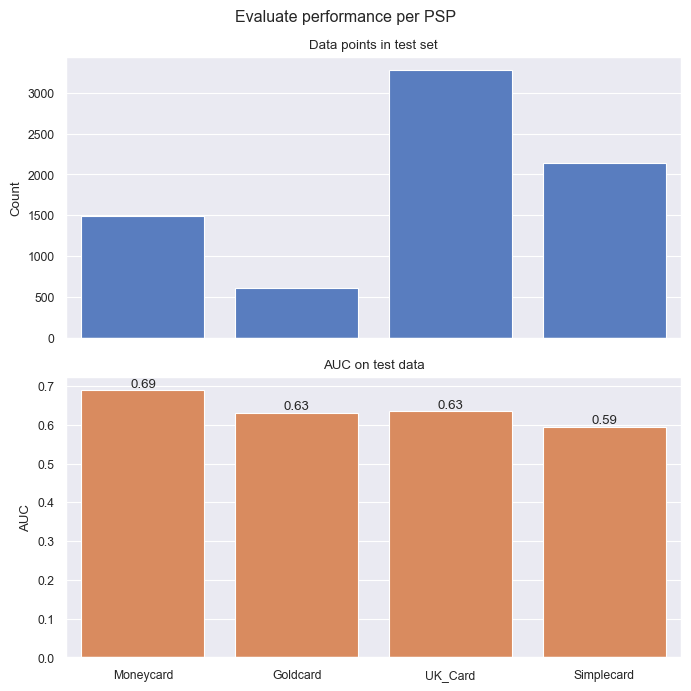

In [34]:
fig, axs = plt.subplots(2,1, figsize=(plot_width-5, plot_height-1), sharex=True, tight_layout=True)
g0 = sns.barplot(x=list(dict_psp_count.keys()), y=list(dict_psp_count.values()), color=color_pal[0], ax=axs[0])
axs[0].set_title("Data points in test set")
axs[0].set(ylabel="Count")

g1 = sns.barplot(x=list(dict_psp_auc.keys()), y=list(dict_psp_auc.values()), color=color_pal[1], ax=axs[1])
axs[1].set_title("AUC on test data")
for i in g1.containers:
    g1.bar_label(i, fmt="%.2f")
axs[1].set(ylabel="AUC")

plt.suptitle("Evaluate performance per PSP")
plt.savefig("../reports/figures/7-2_auc_psp.png")
plt.show()
plt.close()

## AUC for amounts

In [35]:
amount_classes = np.arange(0, 1.1, 0.25)
# search column for amount in features
col_idx = [list(features_light).index(i) for i in features_light if (i.find("amount")!=-1)][0]

# collect results
dict_amount_auc = dict()
dict_amount_count = dict()
dict_amount_avg = dict()
dict_amount_accuracy = dict()
dict_amount_f1 = dict()

for idx, val in enumerate(amount_classes):
    if idx+1 < len(amount_classes):
        # create filter for class
        filter_amount = (x_test_numerical_light[:, col_idx] > val) & (x_test_numerical_light[:, col_idx] <= amount_classes[idx+1])
        x_key = amount_classes[idx+1]

        count = y_pred_probs[filter_amount].shape[0] # count no. of data points
        dict_amount_count[x_key] = count
        
        auc = roc_auc_score(y_test[filter_amount], y_pred_probs[filter_amount])
        dict_amount_auc[x_key] = auc

        avg_prob = np.mean(y_pred_probs[filter_amount]) # average probability
        dict_amount_avg[x_key] = avg_prob

        accuracy = accuracy_score(y_test[filter_amount], y_pred[filter_amount])
        dict_amount_accuracy[x_key] = accuracy

        f1 = f1_score(y_test[filter_amount], y_pred[filter_amount])
        dict_amount_f1[x_key] = f1

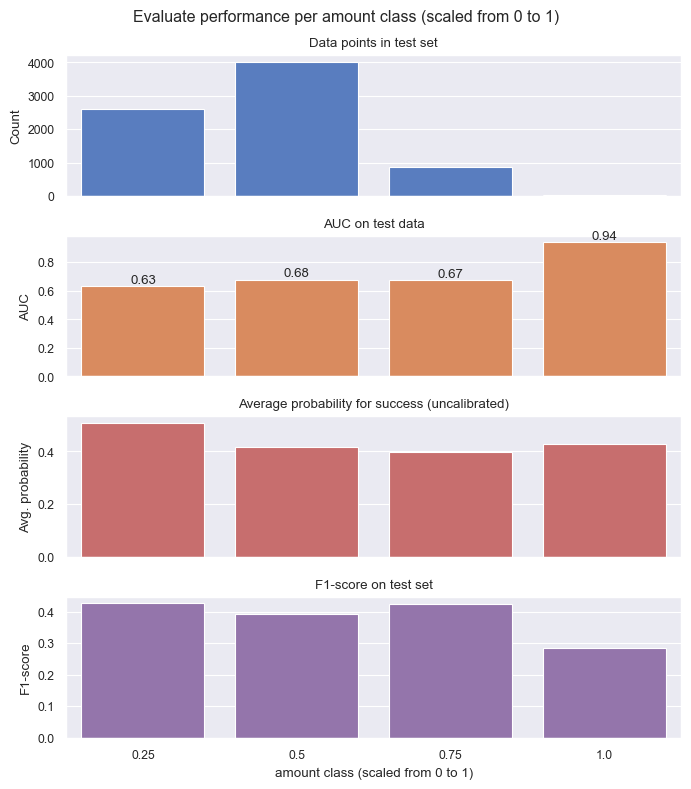

In [36]:
fig, axs = plt.subplots(4,1, figsize=(plot_width-5, plot_height), sharex=True, tight_layout=True)
g0 = sns.barplot(x=list(dict_amount_count.keys()), y=list(dict_amount_count.values()), color=color_pal[0], ax=axs[0])
axs[0].set_title("Data points in test set")
axs[0].set(ylabel="Count")

g1 = sns.barplot(x=list(dict_amount_auc.keys()), y=list(dict_amount_auc.values()), color=color_pal[1], ax=axs[1])
axs[1].set_title("AUC on test data")
for i in g1.containers:
    g1.bar_label(i, fmt="%.2f")
axs[1].set(ylabel="AUC")

g2 = sns.barplot(x=list(dict_amount_avg.keys()), y=list(dict_amount_avg.values()), color=color_pal[3], ax=axs[2])
axs[2].set_title("Average probability for success (uncalibrated)")
axs[2].set(ylabel="Avg. probability")

g3= sns.barplot(x=list(dict_amount_f1.keys()), y=list(dict_amount_f1.values()), color=color_pal[4], ax=axs[3])
axs[3].set_title("F1-score on test set")
axs[3].set(ylabel="F1-score")

plt.xlabel("amount class (scaled from 0 to 1)")
plt.suptitle("Evaluate performance per amount class (scaled from 0 to 1)")
plt.savefig("../reports/figures/7-3_amount.png")
plt.show()
plt.close()

# Probability calibration of Random Forest
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html<br>
https://dataisblue.io/python/data_science/2020/02/16/calibrating-random-forest.html

In [37]:
rf_calib_iso = CalibratedClassifierCV(best_model, cv=5, method="isotonic")
rf_calib_iso.fit(x_train_numerical_light, y_train)
rf_calib_sigm = CalibratedClassifierCV(best_model, cv=5, method="sigmoid")
rf_calib_sigm.fit(x_train_numerical_light, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                        criterion='log_loss',
                                                        max_depth=35,
                                                        min_samples_leaf=29,
                                                        n_estimators=130,
                                                        random_state=23))

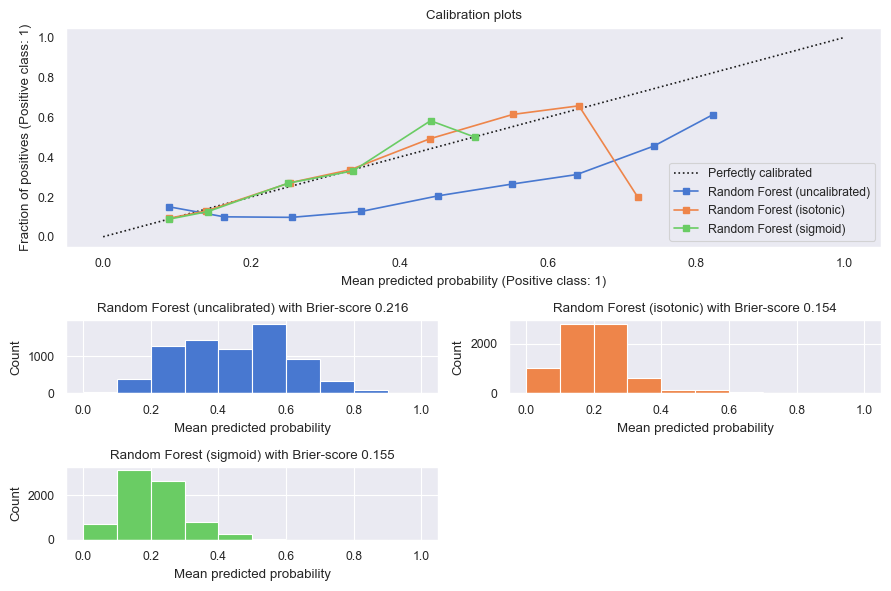

In [38]:
model_list = [(best_model, "Random Forest (uncalibrated)"), 
              (rf_calib_iso, "Random Forest (isotonic)"), 
              (rf_calib_sigm, "Random Forest (sigmoid)")]

fig = plt.figure(figsize=(plot_width-3, plot_height-2))
gs = GridSpec(4, 2)
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
dict_calib_displays = dict()
dict_brier_scores = dict()

for i, (model, name) in enumerate(model_list):
    display = CalibrationDisplay.from_estimator(model, 
                                                x_test_numerical_light, y_test, 
                                                n_bins=10, 
                                                name=name, 
                                                ax=ax_calibration_curve,
                                                color=color_pal[i])
    dict_calib_displays[name] = display
    # calculate Brier's score (mean squared error of predicted probabilities) -> smaller is better
    pred = model.predict_proba(x_test_numerical_light)
    score_brier = brier_score_loss(y_test, pred[:, 1])
    dict_brier_scores[name] = score_brier
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(model_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        dict_calib_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name ,
        color=color_pal[i],
    )
    ax.set(title=(f"{name} with Brier-score {dict_brier_scores[name]:.3f}"), xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.savefig("../reports/figures/8_calbration.png")
plt.show()
plt.close()

# Decision Function

# Deployment

In [101]:
# create random index to pick record from test data
idx_random = random.randrange(0, x_test.shape[0]-1)
# Transaction data from customer
data_in = x_test.iloc[[idx_random], :]
data_in

"""# find columns with encoded PSP-information and set to false
psp_idx = [list(x_test.columns).index(i) for i in x_test.columns if (i.find("enc_psp")!=-1)]
for idx in psp_idx:
    data_in[idx] = False

# create data records for all PSP with transformed data
transf_data_per_psp = dict()
for psp in df_psp_cost["PSP_name"]:
    psp_data = data_in.copy()
    # find column to current PSP
    c_idx = [list(x_test.columns).index(i) for i in x_test.columns if (i.find(psp)!=-1)][0]
    psp_data[c_idx] = True # set TRUE for current PSP
    psp_data_transformed = coltransformer_4numerical.transform(psp_data.reshape(1, -1))
    #transf_data_per_psp[psp] = psp_data_transformed"""

'# find columns with encoded PSP-information and set to false\npsp_idx = [list(x_test.columns).index(i) for i in x_test.columns if (i.find("enc_psp")!=-1)]\nfor idx in psp_idx:\n    data_in[idx] = False\n\n# create data records for all PSP with transformed data\ntransf_data_per_psp = dict()\nfor psp in df_psp_cost["PSP_name"]:\n    psp_data = data_in.copy()\n    # find column to current PSP\n    c_idx = [list(x_test.columns).index(i) for i in x_test.columns if (i.find(psp)!=-1)][0]\n    psp_data[c_idx] = True # set TRUE for current PSP\n    psp_data_transformed = coltransformer_4numerical.transform(psp_data.reshape(1, -1))\n    #transf_data_per_psp[psp] = psp_data_transformed'

In [102]:
type(data_in)

pandas.core.frame.DataFrame